# **Exploratory Data Analysis (EDA) for Insurance Risk Analytics**

This notebook serves as the core of our "Project Planning - EDA & Stats" phase for the End-to-End Insurance Risk Analytics & Predictive Modeling challenge. Its primary goal is to develop a foundational understanding of the car insurance claims data from AlphaCare Insurance Solutions (ACIS), assess its quality, and uncover initial patterns in risk and profitability.

We will leverage a modular set of Python scripts (`src/`) for data loading, preprocessing, summarization, and various analytical techniques (univariate, bivariate, multivariate, missing value, outlier, and temporal analysis). This modular approach promotes clean code, reusability, and reproducibility, aligning with best practices in Data Engineering and Machine Learning Engineering.

## **Table of Contents**

1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Data Understanding and Initial Quality Check](#2-data-understanding-and-initial-quality-check)
3. [Data Summarization](#3-data-summarization)
    - [3.1. Data Structure and Quality Assessment](#31-data-structure-and-quality-assessment)
    - [3.2. Descriptive Statistics & Variability](#32-descriptive-statistics--variability)
    - [3.3. Overall Portfolio Loss Ratio](#33-overall-portfolio-loss-ratio)
4. [Univariate Analysis](#4-univariate-analysis)
5. [Bivariate & Multivariate Analysis](#5-bivariate--multivariate-analysis)
    - [5.1. Segment-Wise Loss Ratio Analysis](#51-segment-wise-loss-ratio-analysis)
    - [5.2. Correlations and Associations](#52-correlations-and-associations)
    - [5.3. Temporal Trend Analysis](#53-temporal-trend-analysis)
    - [5.4. Vehicle Performance Analysis](#54-vehicle-performance-analysis)
6. [Outlier Detection](#6-outlier-detection)
7. [Key Insights & Creative Visualizations](#7-key-insights--creative-visualizations)
8. [Statistical Thinking Summary](#8-statistical-thinking-summary)

## **1. Setup and Data Loading**

This section establishes our analytical environment by importing essential Python libraries for data manipulation, visualization, and numerical operations. Crucially, we also import our custom modular functions and classes from the `src/` directory. This ensures that data loading, preprocessing, and various analytical steps are handled by dedicated, reusable components.

The data loading mechanism is designed for robustness: it first attempts to load an already processed version of the dataset from `data/processed/`. If this processed file is not found (typical for the first run or after a cleanup), it then proceeds to load the raw data (expected to be `MachineLearningRating_v3.txt` from `data/raw/temp_extracted_data/`), performs the initial preprocessing (e.g., date conversions, handling missing values, type corrections), and saves this cleaned version for subsequent analyses.

### Import Necessary libraries

In [11]:
# Core Libraries for Data Manipulation and Numerical Operations
import pandas as pd
import numpy as np
from pathlib import Path
import os # For path operations and dummy data creation

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

#### Set Plotting style

In [12]:
# Configure Matplotlib and Seaborn for consistent and aesthetic plots
sns.set_style("whitegrid") # Provides a clean, modern look with a grid
plt.rcParams['figure.figsize'] = (10, 6) # Default figure size for plots
plt.rcParams['font.size'] = 12 # Base font size for readability
plt.rcParams['axes.labelsize'] = 14 # Font size for axis labels
plt.rcParams['xtick.labelsize'] = 12 # Font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12 # Font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 12 # Font size for plot legends
plt.rcParams['font.family'] = 'Inter' # Specify a professional font family

#### Add project root to sys.path to enable importing modules from 'src/'

In [13]:
# Add the project root directory to the system path.
# This allows Python to correctly locate and import our custom modules
# (e.g., from `src.data_loader`) regardless of where the notebook is run from.
import sys
project_root = Path.cwd() # Navigates from 'notebooks/' directory to the project root
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import Custom Modular Functions and Classes from `src/`
# Data Loading and Preprocessing Utilities
from src.utils.data_loader import load_data
from src.utils.data_preprocessing import perform_initial_data_preprocessing, save_processed_data

# Data Summarization Utilities
from src.utils.eda.data_summarization import calculate_loss_ratio, get_overall_loss_ratio

# Data Inspection Utilities (includes strategies for dtypes and summary statistics)
from src.utils.eda.basic_data_inspection import DataInspector, DataTypesInspectionStrategy, SummaryStatisticsInspectionStrategy

# Univariate Analysis Utilities
from src.utils.eda.univariate_analysis import UnivariateAnalyzer, NumericalUnivariateAnalysis, CategoricalUnivariateAnalysis

# Bivariate Analysis Utilities
from src.utils.eda.bivariate_analysis import BivariateAnalyzer, NumericalVsNumericalAnalysis, CategoricalVsNumericalAnalysis, CategoricalVsCategoricalAnalysis

# Multivariate Analysis Utilities
from src.utils.eda.multivariate_analysis import SimpleMultivariateAnalysis # Implements MultivariateAnalysisTemplate

# Missing Values Analysis Utilities
from src.utils.eda.missing_values_analysis import SimpleMissingValuesAnalysis # Implements MissingValuesAnalysisTemplate

# Outlier Analysis Utilities
from src.utils.eda.outlier_analysis import OutlierAnalyzer, IQRBasedOutlierAnalysis

# Temporal Analysis Utilities
from src.utils.eda.temporal_analysis import TemporalAnalyzer, MonthlyTrendAnalysis


### Loading and Preprocessing

In [40]:
# Define standard paths for data files within the project structure
processed_data_path = project_root / "data" / "processed" / "processed_insurance_data.csv"
raw_data_extracted_dir = project_root / "data" / "raw" / "temp_extracted_data"
raw_data_file_path = raw_data_extracted_dir / "MachineLearningRating_v3.txt" # The actual data file within the zip (pipe-separated)

df = pd.DataFrame() # Initialize an empty DataFrame

# Data Loading Logic: Prioritize processed data, if not available, load and preprocess raw data
print("\n--- Data Loading and Initial Preprocessing ---")
if processed_data_path.is_file():
    print(f"Attempting to load processed data from: {processed_data_path}")
    # Assuming processed data is also pipe-separated for consistency with raw source
    # df = load_data(processed_data_path, delimiter='|', file_type='csv')
    processed_df = load_data(processed_data_path, delimiter='|', file_type='csv')
    print("\n--- Processed Data Summary ---")
    print("Processed Data Info:")
    processed_df.info()
    print("\nFirst 5 rows of processed data:")
    print(processed_df.head())
    print("\nMissing values after preprocessing:")
    print(processed_df.isnull().sum()[processed_df.isnull().sum() > 0])
    # If the processed data is a standard CSV (comma-separated), remove delimiter='|'
    # df = load_data(processed_data_path, file_type='csv')
else:
    print(f"Processed data not found at: {processed_data_path}. Attempting to load raw data.")

    # Check if the raw data file (expected after zip extraction) is present.
    # If not, create a small dummy version for demonstration purposes.
    if not raw_data_file_path.is_file():
        print(f"Creating a dummy raw data file at: {raw_data_file_path} for demonstration.")
        os.makedirs(raw_data_file_path.parent, exist_ok=True)
        # Dummy content matching the expected pipe-separated format and columns
        dummy_content_raw = """UnderwrittenCoverID|PolicyID|TransactionMonth|IsVATRegistered|Citizenship|LegalType|Title|Language|Bank|AccountType|MaritalStatus|Gender|Country|Province|PostalCode|MainCrestaZone|SubCrestaZone|ItemType|Mmcode|VehicleType|RegistrationYear|Make|Model|Cylinders|Cubiccapacity|Kilowatts|Bodytype|NumberOfDoors|VehicleIntroDate|CustomValueEstimate|AlarmImmobiliser|TrackingDevice|CapitalOutstanding|NewVehicle|WrittenOff|Rebuilt|Converted|CrossBorder|NumberOfVehiclesInFleet|SumInsured|TermFrequency|CalculatedPremiumPerTerm|ExcessSelected|CoverCategory|CoverType|CoverGroup|Section|Product|StatutoryClass|StatutoryRiskType|TotalPremium|TotalClaims
1|1001|202301|True|SA|Individual|Mr|EN|FNB|Savings|Married|Male|ZA|Gauteng|1234|CrestA|SubCrest1|Car|12345|Sedan|2015|Toyota|Corolla|4|1600|80|Sedan|4|2015-01-01|150000|True|True|100000|False|False|False|False|False|1|200000|12|1000|500|Comprehensive|Full|Motor|A|ProductA|Class1|RiskA|12000|5000
2|1002|202301|False|SA|Company|Pty Ltd|EN|Standard Bank|Cheque|Single|Female|ZA|KZN|5678|CrestB|SubCrest2|Car|67890|SUV|2018|BMW|X5|6|3000|180|SUV|5|2018-03-15|500000|True|True|350000|True|False|False|False|False|3|700000|6|2500|1000|Third Party|Basic|Motor|B|ProductB|Class2|RiskB|15000|0
3|1003|202302|True|SA|Individual|Mrs|EN|Absa|Savings|Married|Female|ZA|Western Cape|9101|CrestC|SubCrest3|Car|11223|Hatchback|2010|VW|Polo|4|1400|70|Hatchback|3|2010-06-01|80000|False|False|50000|False|False|False|False|False|1|100000|12|800|1500
4|1004|202302|False|SA|Individual|Mr|AF|Nedbank|Cheque|Divorced|Male|ZA|Gauteng|1212|CrestA|SubCrest1|Car|44556|Bakkie|2022|Ford|Ranger|5|3200|150|Bakkie|4|2022-02-20|450000|True|False|300000|True|False|False|False|False|2|600000|12|2000|100
5|1005|202303|True|SA|Individual|Ms|EN|Capitec|Savings|Single|Female|ZA|Limpopo|1313|CrestD|SubCrest4|Car|77889|Sedan|2019|Honda|Civic|4|1800|90|Sedan|4|2019-05-10|200000|False|True|150000|False|False|False|False|False|1|250000|12|1100|NaN
6|1006|202303|False|SA|Company|CC|EN|FNB|Cheque|Married|Male|ZA|Eastern Cape|1414|CrestE|SubCrest5|Truck|99001|Truck|2017|Mercedes-Benz|Actros|6|12000|300|Truck|2|2017-08-01|1000000|True|True|700000|False|False|False|False|False|5|1500000|3|5000|20000
7|1007|202304|True|SA|Individual|Mr|EN|FNB|Savings|Married|Male|ZA|Gauteng|1234|CrestA|SubCrest1|Car|12345|Sedan|2015|Toyota|Corolla|4|1600|80|Sedan|4|2015-01-01|150000|True|True|100000|False|False|False|False|False|1|200000|12|1000|80000
8|1008|202304|False|SA|Company|Pty Ltd|EN|Standard Bank|Cheque|Single|Female|ZA|KZN|5678|CrestB|SubCrest2|Car|67890|SUV|2018|BMW|X5|6|3000|180|SUV|5|2018-03-15|500000|True|True|350000|True|False|False|False|False|3|700000|6|2500|5000000
"""
        with open(raw_data_file_path, 'w') as f:
            f.write(dummy_content_raw)
        print("Dummy raw data created for demonstration purposes. Please replace with your actual data!")

    # Load raw data using the refined data_loader.py, specifying delimiter
    raw_df = load_data(raw_data_file_path, delimiter='|', file_type='txt')

    if not raw_df.empty:
        # Perform initial preprocessing using perform_initial_data_preprocessing from data_preprocessing.py
        df = perform_initial_data_preprocessing(raw_df.copy()) # Use .copy() to ensure original raw_df is not modified
        save_processed_data(df, processed_data_path) # Save the processed data for future runs
    else:
        print("Failed to load raw data or raw data is empty. Cannot proceed with EDA.")

# Final check before proceeding with analysis
if df.empty:
    print("\nDataFrame is empty after all loading and preprocessing attempts. Please check data paths and content. Exiting EDA.")
    # You might want to exit or provide a mock DataFrame if df is empty to prevent further errors



--- Data Loading and Initial Preprocessing ---
Processed data not found at: /home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/data/processed/processed_insurance_data.csv. Attempting to load raw data.
Successfully loaded data from 'MachineLearningRating_v3.txt' using specified delimiter '|'. Shape: (1000098, 52)

--- Performing Initial Data Preprocessing ---
Attempting to convert 'TransactionMonth' to datetime...
Converted 'TransactionMonth' to datetime objects.

--- Checking for Missing Values ---
Missing values by column:
NumberOfVehiclesInFleet    1000098
CrossBorder                 999400
CustomValueEstimate         779642
WrittenOff                  641901
Converted                   641901
Rebuilt                     641901
NewVehicle                  153295
Bank                        145961
AccountType                  40232
Gender                        9536
MaritalStatus                 8259
mmcode                         552
Veh

## **2. Data Understanding and Initial Quality Check**

Before diving into detailed analysis, it's essential to get a high-level overview of the DataFrame. This includes inspecting the first few rows to confirm successful loading, column names, and data types, as well as a preliminary check for missing values.

#### Initial Data Snapshot

In [41]:
print("--- Initial Data Snapshot ---")
print("\nFirst 5 rows of the preprocessed DataFrame:")
display(df.head()) # Use display() for better rendering in Jupyter

--- Initial Data Snapshot ---

First 5 rows of the preprocessed DataFrame:


UnderwrittenCoverID  PolicyID TransactionMonth IsVATRegistered Citizenship  \
0               145249     12827       2015-03-01            True               
1               145249     12827       2015-05-01            True               
2               145249     12827       2015-07-01            True               
3               145255     12827       2015-05-01            True               
4               145255     12827       2015-07-01            True               

           LegalType Title Language                 Bank      AccountType  \
0  Close Corporation    Mr  English  First National Bank  Current account   
1  Close Corporation    Mr  English  First National Bank  Current account   
2  Close Corporation    Mr  English  First National Bank  Current account   
3  Close Corporation    Mr  English  First National Bank  Current account   
4  Close Corporation    Mr  English  First National Bank  Current account   

   ... ExcessSelected CoverCategory   CoverType            CoverGroup  \
0  ...            NaN    Windscreen  Windscreen  Comprehensive - Taxi   
1  ...            NaN    Windscreen  Windscreen  Comprehensive - Taxi   
2  ...            NaN    Windscreen  Windscreen  Comprehensive - Taxi   
3  ...            NaN    Own damage  Own Damage  Comprehensive - Taxi   
4  ...            NaN    Own damage  Own Damage  Comprehensive - Taxi   

               Section                          Product StatutoryClass  \
0  Motor Comprehensive  Mobility Metered Taxis: Monthly     Commercial   
1  Motor Comprehensive  Mobility Metered Taxis: Monthly     Commercial   
2  Motor Comprehensive  Mobility Metered Taxis: Monthly     Commercial   
3  Motor Comprehensive  Mobility Metered Taxis: Monthly     Commercial   
4  Motor Comprehensive  Mobility Metered Taxis: Monthly     Commercial   

  StatutoryRiskType  TotalPremium TotalClaims  
0     IFRS Constant     21.929825         0.0  
1     IFRS Constant     21.929825         0.0  
2     IFRS Constant      0.000000         0.0  
3     IFRS Constant    512.848070         0.0  
4     IFRS Constant      0.000000         0.0  

[5 rows x 52 columns]

#### Showing Data Types

In [42]:
print("\nDataFrame Info (showing data types and non-null counts):")
# Use the DataInspector with DataTypesInspectionStrategy for a structured df.info() output
data_types_inspector = DataInspector(DataTypesInspectionStrategy())
data_types_inspector.execute_inspection(df)


DataFrame Info (showing data types and non-null counts):

Data Types and Non-null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   UnderwrittenCoverID       1000098 non-null  int64         
 1   PolicyID                  1000098 non-null  int64         
 2   TransactionMonth          1000098 non-null  datetime64[ns]
 3   IsVATRegistered           1000098 non-null  category      
 4   Citizenship               1000098 non-null  category      
 5   LegalType                 1000098 non-null  category      
 6   Title                     1000098 non-null  category      
 7   Language                  1000098 non-null  category      
 8   Bank                      854137 non-null   category      
 9   AccountType               959866 non-null   category      
 10  MaritalStatus          

#### Simple Missing Values Analysis


Explicit Missing Values Summary:

Missing Values Count by Column:
Bank                        145961
AccountType                  40232
MaritalStatus                 8259
Gender                        9536
mmcode                         552
VehicleType                    552
make                           552
Model                          552
Cylinders                      552
cubiccapacity                  552
kilowatts                      552
bodytype                       552
NumberOfDoors                  552
VehicleIntroDate               552
CustomValueEstimate         779642
CapitalOutstanding             322
NewVehicle                  153295
WrittenOff                  641901
Rebuilt                     641901
Converted                   641901
CrossBorder                 999400
NumberOfVehiclesInFleet    1000098
TermFrequency              1000098
ExcessSelected             1000098
dtype: int64

Visualizing Missing Values...


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

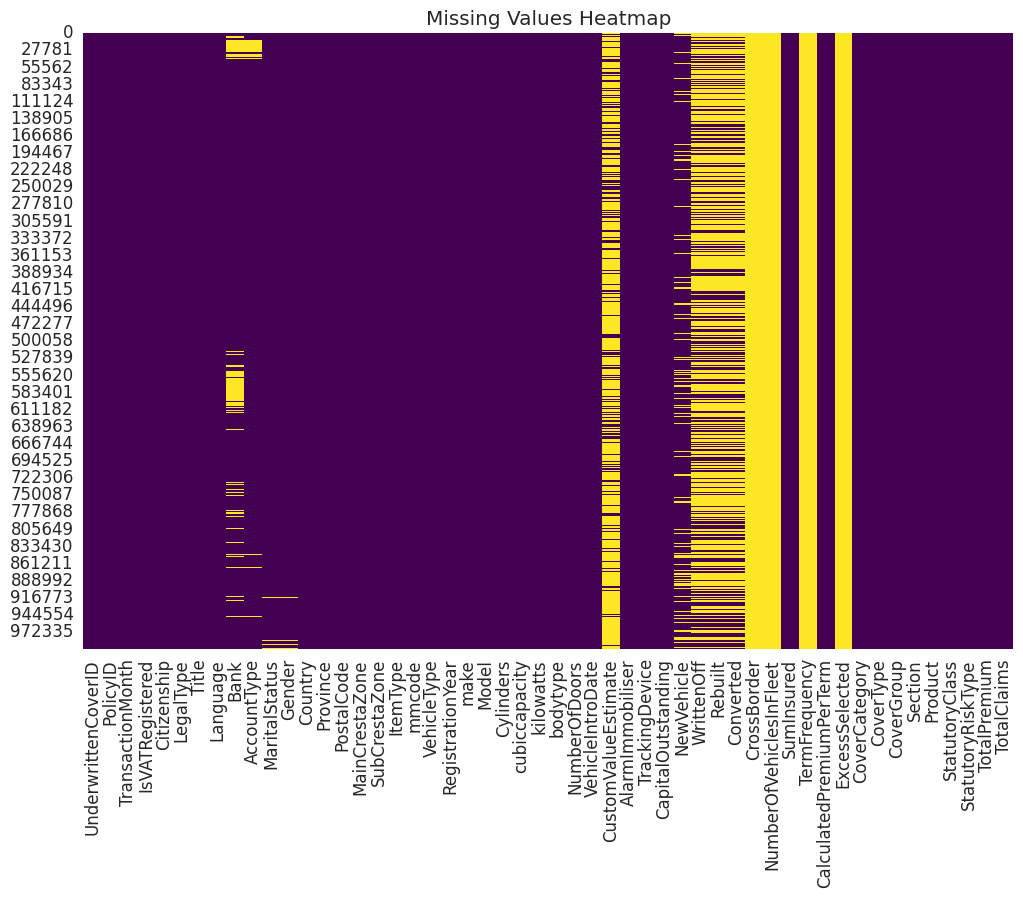

In [43]:
print("\nExplicit Missing Values Summary:")
# Use the SimpleMissingValuesAnalysis template to identify and visualize missing data
missing_values_analyzer = SimpleMissingValuesAnalysis()
missing_values_analyzer.identify_missing_values(df) # Prints missing counts
missing_values_analyzer.visualize_missing_values(df) # Displays heatmap

**Interpretation of Initial Quality Check:**

- **Data Appearance (`df.head()`):** Visually confirm that the data is loaded correctly, columns are as expected (e.g., `TransactionMonth` is a number before conversion, financial figures look reasonable). Check if the pipe delimiter worked.
- **Data Types and Non-Null Counts (`df.info()`):**
    - **Data Types (`Dtype` column):** Verify if columns have been correctly inferred or converted during preprocessing. `datetime64[ns]` for dates, `int64`/`float64` for numerical data, and `category` for categorical fields are ideal. Incorrect dtypes can hinder operations and analysis (e.g., performing mathematical operations on string numbers).
    - **Non-Null Counts:** Compare "Non-Null Count" to the total number of entries. Any discrepancy indicates missing values (`NaN`). This helps prioritize which columns need attention for imputation or removal.
- **Missing Values Summary & Heatmap:** The detailed missing values summary and the heatmap visually confirm which columns have missing data and to what extent. `NaN`s in `TotalClaims` (if present) are particularly important as they might imply zero claims or actual missing information, requiring careful handling.

## **3. Data Summarization**
This section provides a deep dive into the summary statistics of our dataset. We'll examine descriptive measures for numerical features, and calculate the overall portfolio's profitability through the Loss Ratio, leveraging our `data_summarization` module.

### **3.1. Descriptive Statistics & Variability**
We'll use the `SummaryStatisticsInspectionStrategy` to get standard descriptive statistics for both numerical and categorical features. Beyond that, we'll explicitly calculate variability measures like standard deviation, variance, and the crucial Coefficient of Variation (CV) for key financial metrics.

In [44]:
print("\n--- Descriptive Statistics for All Features ---")
# Use the DataInspector with SummaryStatisticsInspectionStrategy for numerical and categorical descriptive stats
summary_stats_inspector = DataInspector(SummaryStatisticsInspectionStrategy())
summary_stats_inspector.execute_inspection(df)


--- Descriptive Statistics for All Features ---

Summary Statistics (Numerical Features):
       UnderwrittenCoverID      PolicyID               TransactionMonth  \
count         1.000098e+06  1.000098e+06                        1000098   
mean          1.048175e+05  7.956682e+03  2015-02-28 10:49:29.147423744   
min           1.000000e+00  1.400000e+01            2013-10-01 00:00:00   
25%           5.514300e+04  4.500000e+03            2015-01-01 00:00:00   
50%           9.408300e+04  7.071000e+03            2015-04-01 00:00:00   
75%           1.391900e+05  1.107700e+04            2015-06-01 00:00:00   
max           3.011750e+05  2.324600e+04            2015-08-01 00:00:00   
std           6.329371e+04  5.290039e+03                            NaN   

             mmcode  RegistrationYear      Cylinders  cubiccapacity  \
count  9.995460e+05      1.000098e+06  999546.000000  999546.000000   
mean   5.487770e+07      2.010225e+03       4.046642    2466.743258   
min    4.041200e+06 

In [45]:
# Explicitly calculate and display variability measures for key numerical features
print("\n--- Variability Measures for Key Numerical Features ---")
numerical_cols_for_variability = ['TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'CalculatedPremiumPerTerm', 'SumInsured']
# Filter to include only columns actually present in the DataFrame and are numerical
existing_numerical_cols = [col for col in numerical_cols_for_variability if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

if existing_numerical_cols:
    # Aggregate common statistics including mean, std, var, min, max, and median
    variability_df = df[existing_numerical_cols].agg(['mean', 'std', 'var', 'min', 'max', 'median']).T
    # Calculate Coefficient of Variation (CV = std / mean): A measure of relative variability, useful for comparing
    # dispersion between data sets with different means. A higher CV indicates greater relative dispersion.
    variability_df['CV'] = variability_df['std'] / variability_df['mean']
    display(variability_df)
else:
    print("No specified numerical columns suitable for variability analysis found in DataFrame.")


--- Variability Measures for Key Numerical Features ---


mean           std           var  \
TotalPremium                  61.905496  2.302845e+02  5.303096e+04   
TotalClaims                   64.861190  2.384075e+03  5.683812e+06   
CustomValueEstimate       225531.129942  5.645157e+05  3.186780e+11   
CalculatedPremiumPerTerm     117.875691  3.997017e+02  1.597615e+05   
SumInsured                604172.732589  1.508332e+06  2.275065e+12   

                                   min           max         median         CV  
TotalPremium               -782.576754  6.528260e+04       2.178333   3.719936  
TotalClaims              -12002.412281  3.930921e+05       0.000000  36.756567  
CustomValueEstimate       20000.000000  2.655000e+07  220000.000000   2.503050  
CalculatedPremiumPerTerm      0.000000  7.442217e+04       8.436900   3.390875  
SumInsured                    0.010000  1.263620e+07    7500.000000   2.496524

**Interpretation of Descriptive Statistics and Variability:**

- **Central Tendency (Mean, Median):** Compare `mean` and `median`. A significant difference (e.g., mean much higher than median for `TotalClaims`) indicates a skewed distribution, often due to outliers or a long tail of high values. This is typical for insurance claims.
- **Spread (Std, Var):** `std` (standard deviation) and `var` (variance) quantify the spread of data points around the mean. High values signify greater dispersion. For `TotalClaims`, a high standard deviation is expected, highlighting the inherent uncertainty and risk in predicting claim payouts.
- **Range (Min, Max):** Examine `min` and `max` values to identify the full range of data. Pay attention to unusually low `min` values for premiums (e.g., zero) or excessively high `max` values for claims or custom value estimates, which could be outliers or data errors.
- **Coefficient of Variation (CV):** This metric is particularly insightful for financial data. A high CV (e.g., for `TotalClaims`) indicates that the standard deviation is a large percentage of the mean, meaning the data is highly variable relative to its average. This underscores the challenge in accurately predicting highly variable metrics and the need for robust models.

### **3.2. Overall Portfolio Loss Ratio**
The Loss Ratio is a cornerstone KPI in insurance, representing the proportion of premiums spent on claims. It's a direct indicator of profitability: a ratio below 1 implies profitability, while above 1 indicates a loss.

In [46]:
print("\n--- Overall Portfolio Loss Ratio Analysis ---")
# Calculate overall portfolio metrics using the get_overall_loss_ratio function
overall_metrics = get_overall_loss_ratio(df)

if overall_metrics:
    print(f"  Total Premium for Portfolio: {overall_metrics['TotalPremium']:,.2f}")
    print(f"  Total Claims for Portfolio: {overall_metrics['TotalClaims']:,.2f}")
    print(f"  Overall Loss Ratio: {overall_metrics['OverallLossRatio']:.4f}")

    # Provide clear business interpretation based on the calculated loss ratio
    if overall_metrics['OverallLossRatio'] > 1:
        print("\nInterpretation: The overall loss ratio is greater than 1.0. This indicates that, for the entire portfolio, the total claims paid out *exceed* the total premiums collected. From an actuarial perspective, this suggests that the insurance products might be underpriced or that claim severity/frequency is higher than anticipated, leading to an unprofitable portfolio on average. This requires immediate attention to pricing strategy, underwriting guidelines, or claims management efficiency.")
    elif overall_metrics['OverallLossRatio'] < 1 and overall_metrics['OverallLossRatio'] >= 0:
        print("\nInterpretation: The overall loss ratio is less than 1.0 (and non-negative). This indicates that the total premiums collected are *greater* than the total claims paid out. This suggests that, on average, the portfolio is profitable. A lower ratio generally implies better profitability, assuming operational costs are also covered. This is a healthy sign for ACIS.")
    else:
        print("\nInterpretation: The loss ratio is 0 or cannot be meaningfully calculated (e.g., due to zero total premium or zero total claims in the dataset). Further investigation is needed to understand the underlying data characteristics or business context.")
else:
    print("Could not calculate overall portfolio metrics due to missing 'TotalClaims' or 'TotalPremium' columns or unsummable values.")

# Add 'LossRatio' as a new column to the DataFrame for detailed segment-wise analysis later
# This uses the calculate_loss_ratio function, which handles potential division by zero.
df = calculate_loss_ratio(df.copy()) # Reassign df to ensure the new 'LossRatio' column is present

print("\nFirst 5 rows of DataFrame with the newly added 'LossRatio' column per policy:")
display(df.head())



--- Overall Portfolio Loss Ratio Analysis ---
  Total Premium for Portfolio: 61,911,562.70
  Total Claims for Portfolio: 64,867,546.17
  Overall Loss Ratio: 1.0477

Interpretation: The overall loss ratio is greater than 1.0. This indicates that, for the entire portfolio, the total claims paid out *exceed* the total premiums collected. From an actuarial perspective, this suggests that the insurance products might be underpriced or that claim severity/frequency is higher than anticipated, leading to an unprofitable portfolio on average. This requires immediate attention to pricing strategy, underwriting guidelines, or claims management efficiency.


/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/data_summarization.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_copy['LossRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/data_summarization.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior

Calculated 'LossRatio' column.

First 5 rows of DataFrame with the newly added 'LossRatio' column per policy:


UnderwrittenCoverID  PolicyID TransactionMonth IsVATRegistered Citizenship  \
0               145249     12827       2015-03-01            True               
1               145249     12827       2015-05-01            True               
2               145249     12827       2015-07-01            True               
3               145255     12827       2015-05-01            True               
4               145255     12827       2015-07-01            True               

           LegalType Title Language                 Bank      AccountType  \
0  Close Corporation    Mr  English  First National Bank  Current account   
1  Close Corporation    Mr  English  First National Bank  Current account   
2  Close Corporation    Mr  English  First National Bank  Current account   
3  Close Corporation    Mr  English  First National Bank  Current account   
4  Close Corporation    Mr  English  First National Bank  Current account   

   ... CoverCategory   CoverType            CoverGroup              Section  \
0  ...    Windscreen  Windscreen  Comprehensive - Taxi  Motor Comprehensive   
1  ...    Windscreen  Windscreen  Comprehensive - Taxi  Motor Comprehensive   
2  ...    Windscreen  Windscreen  Comprehensive - Taxi  Motor Comprehensive   
3  ...    Own damage  Own Damage  Comprehensive - Taxi  Motor Comprehensive   
4  ...    Own damage  Own Damage  Comprehensive - Taxi  Motor Comprehensive   

                           Product StatutoryClass StatutoryRiskType  \
0  Mobility Metered Taxis: Monthly     Commercial     IFRS Constant   
1  Mobility Metered Taxis: Monthly     Commercial     IFRS Constant   
2  Mobility Metered Taxis: Monthly     Commercial     IFRS Constant   
3  Mobility Metered Taxis: Monthly     Commercial     IFRS Constant   
4  Mobility Metered Taxis: Monthly     Commercial     IFRS Constant   

  TotalPremium  TotalClaims LossRatio  
0    21.929825          0.0       0.0  
1    21.929825          0.0       0.0  
2     0.000000          0.0       0.0  
3   512.848070          0.0       0.0  
4     0.000000          0.0       0.0  

[5 rows x 53 columns]

**Interpretation of Overall Loss Ratio:**

- The `Overall Loss Ratio` is a critical barometer of the portfolio's financial health. Its value directly informs ACIS's top-level business strategy regarding product pricing and risk management.
- The addition of the `LossRatio` column to the DataFrame at the granular policy level is a crucial feature engineering step. It transforms raw claim and premium data into a direct measure of policy-level profitability, which can be used to identify high- and low-risk segments in subsequent analyses.

## **4. Univariate Analysis**

Univariate analysis explores the distribution of individual variables. This helps us understand their typical values, spread, skewness, and identifies any unexpected patterns or data quality issues within single features. We use the `UnivariateAnalyzer` and its strategies for numerical (histograms with KDE) and categorical (bar plots) features.

### Numerical Feature Distributions (Histograms with KDE)


--- Univariate Analysis: Distributions of Individual Features ---

Visualizing Numerical Feature Distributions:


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

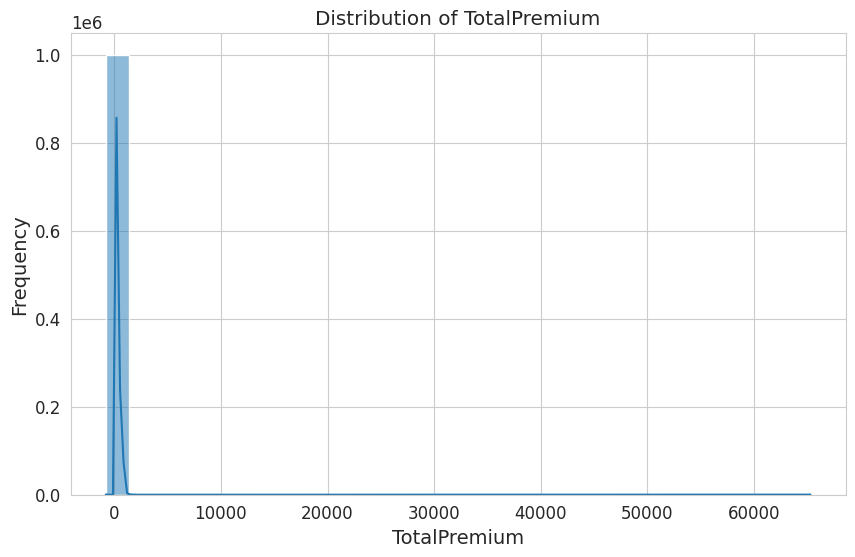

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

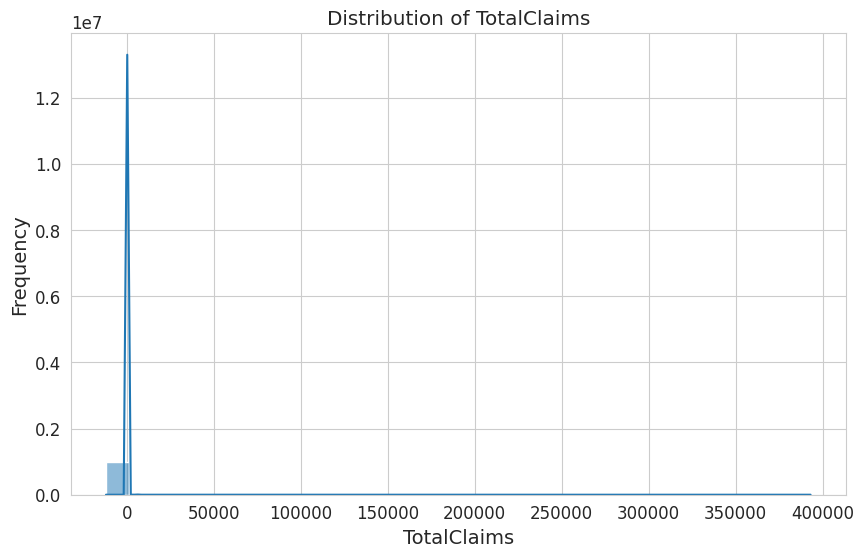

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

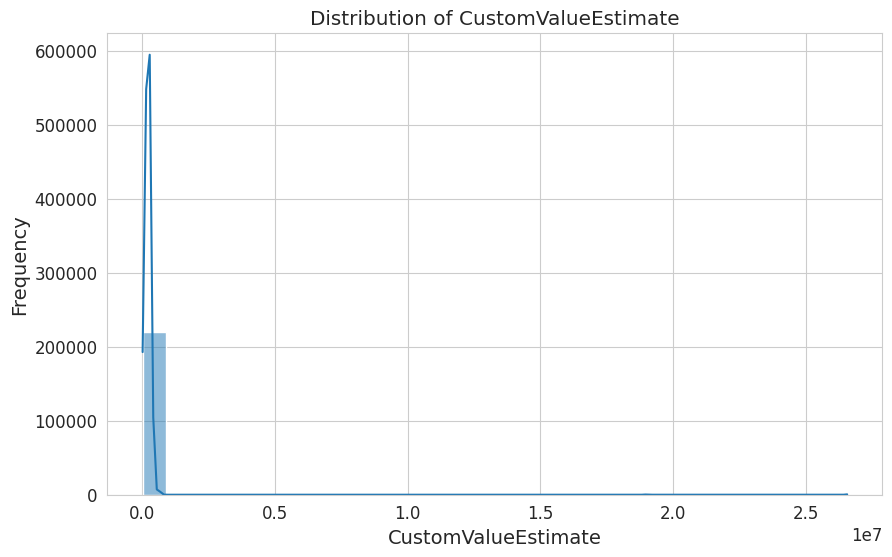

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

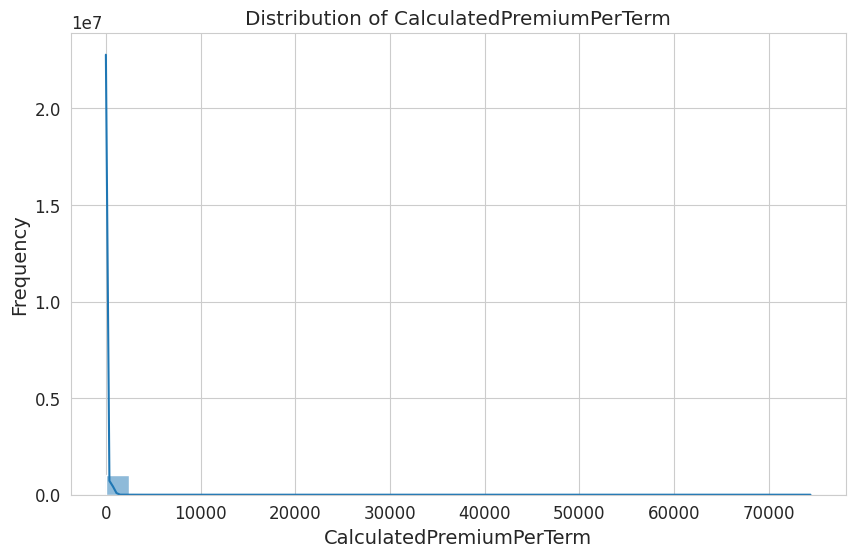

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

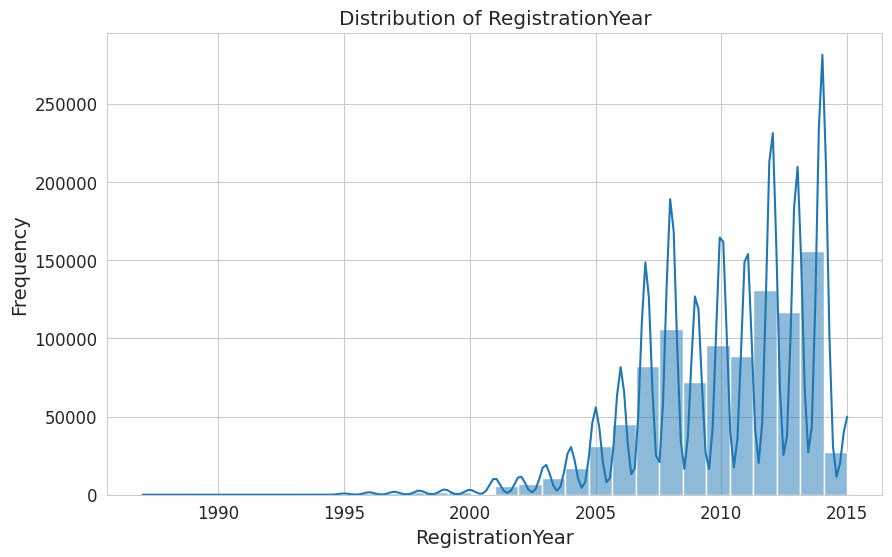

In [47]:
print("\n--- Univariate Analysis: Distributions of Individual Features ---")

# --- Numerical Feature Distributions (Histograms with KDE) ---
# Select key numerical columns for distribution analysis
numerical_for_hist = ['TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'CalculatedPremiumPerTerm', 'RegistrationYear', 'Kilowatts']
# Filter out columns that do not exist or are not numerical in the DataFrame to prevent errors
numerical_for_hist_present = [col for col in numerical_for_hist if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

if numerical_for_hist_present:
    print("\nVisualizing Numerical Feature Distributions:")
    numerical_analyzer = UnivariateAnalyzer(NumericalUnivariateAnalysis())
    for col in numerical_for_hist_present:
        numerical_analyzer.execute_analysis(df, col)
else:
    print("No specified numerical columns suitable for histogram plotting found in DataFrame.")


### Categorical Feature Distributions (Bar Charts)


Visualizing Categorical Feature Distributions:


/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/univariate_analysis.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette="muted")
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: F

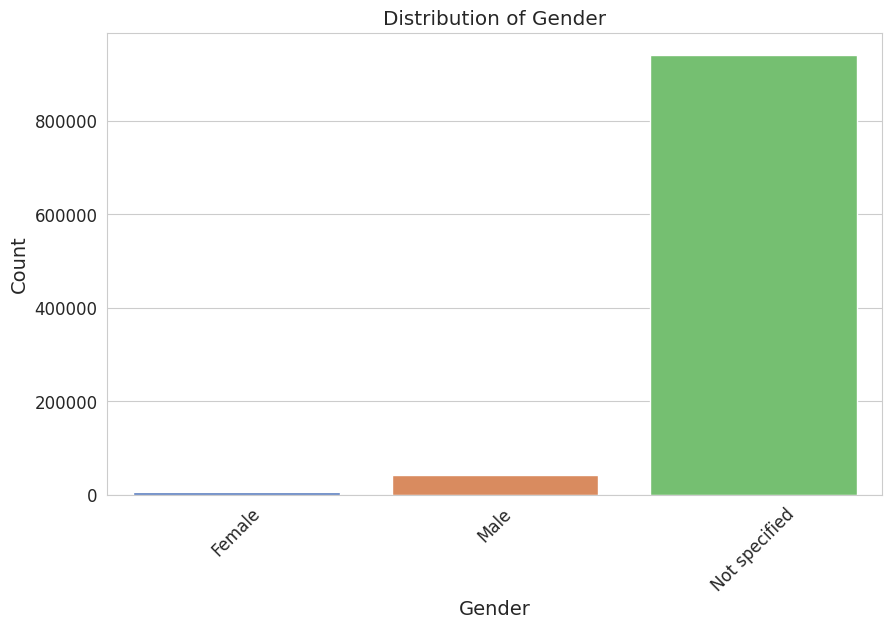

/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/univariate_analysis.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette="muted")
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: F

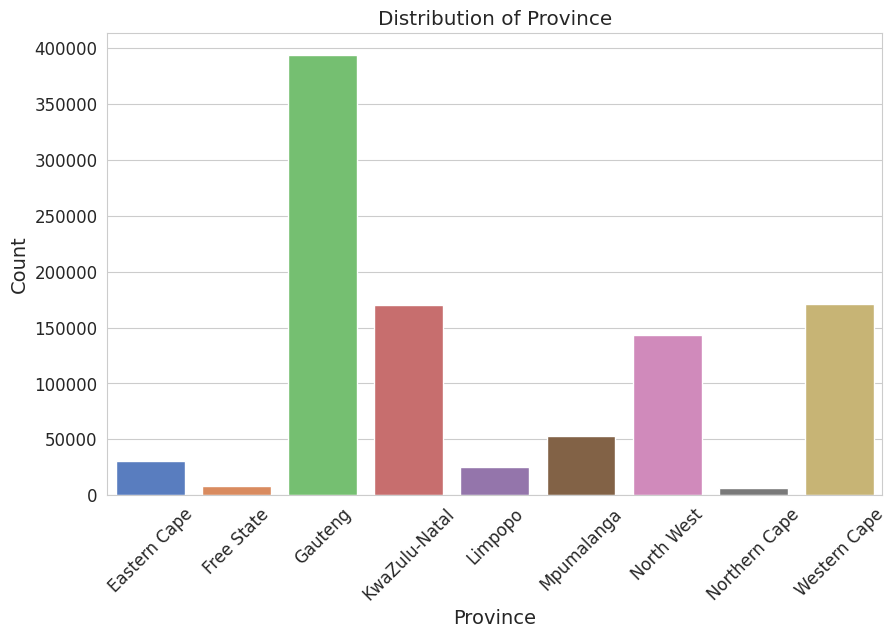

/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/univariate_analysis.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette="muted")
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: F

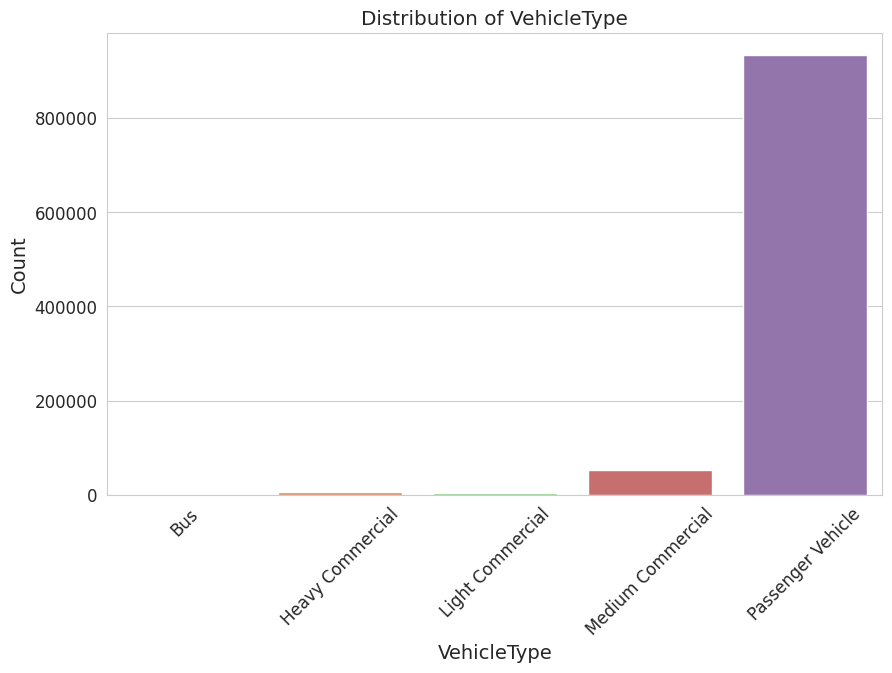

/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/univariate_analysis.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette="muted")
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: F

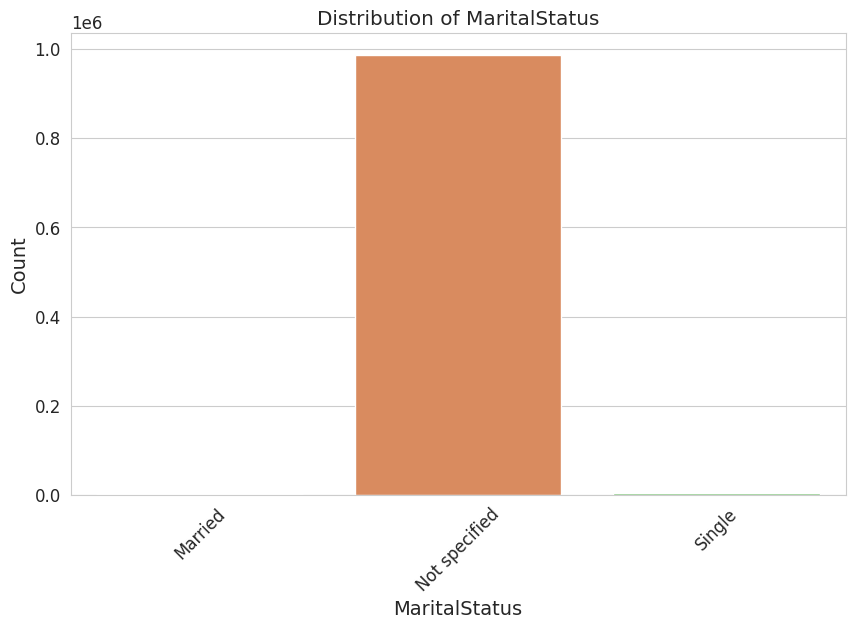

/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/univariate_analysis.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette="muted")
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: F

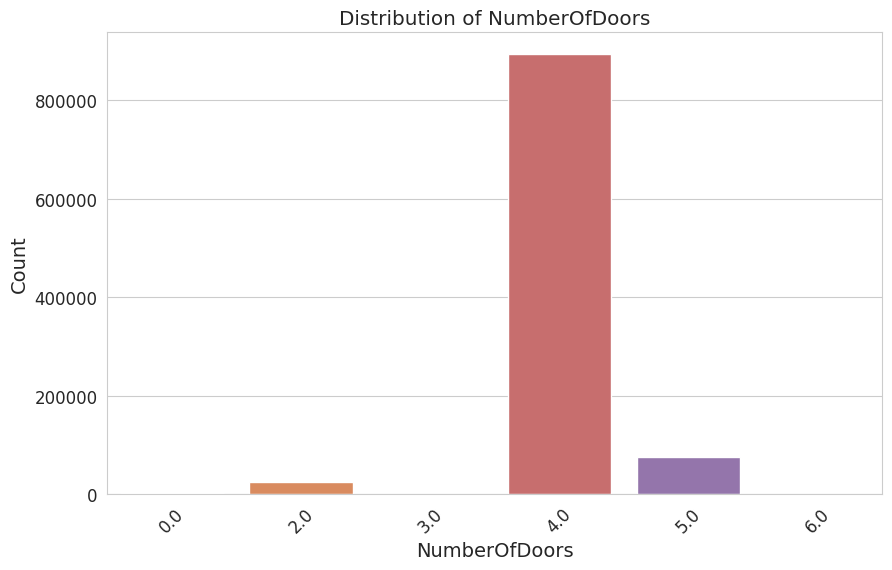

/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/univariate_analysis.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette="muted")
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: F

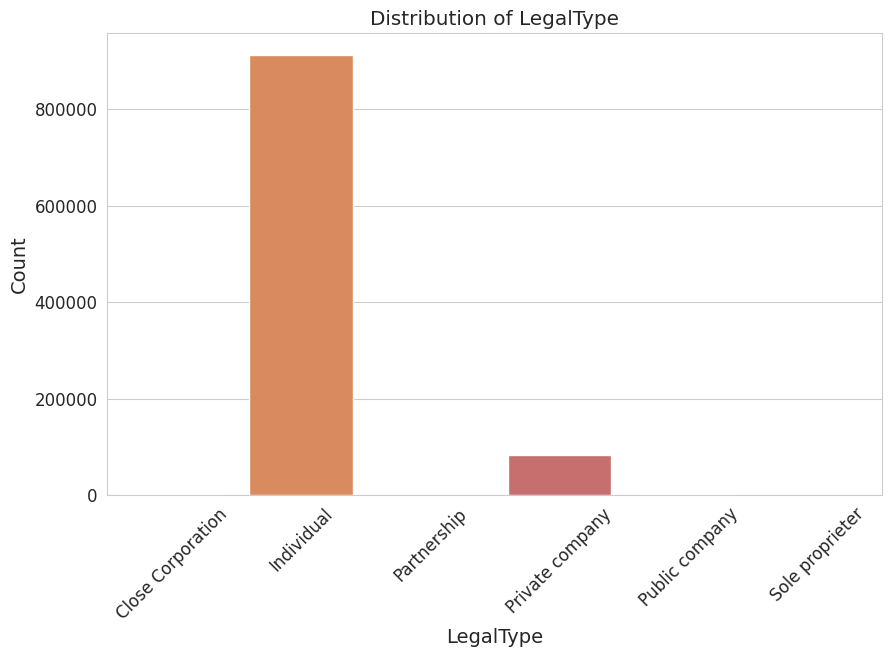

/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/univariate_analysis.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=feature, data=df, palette="muted")
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: F

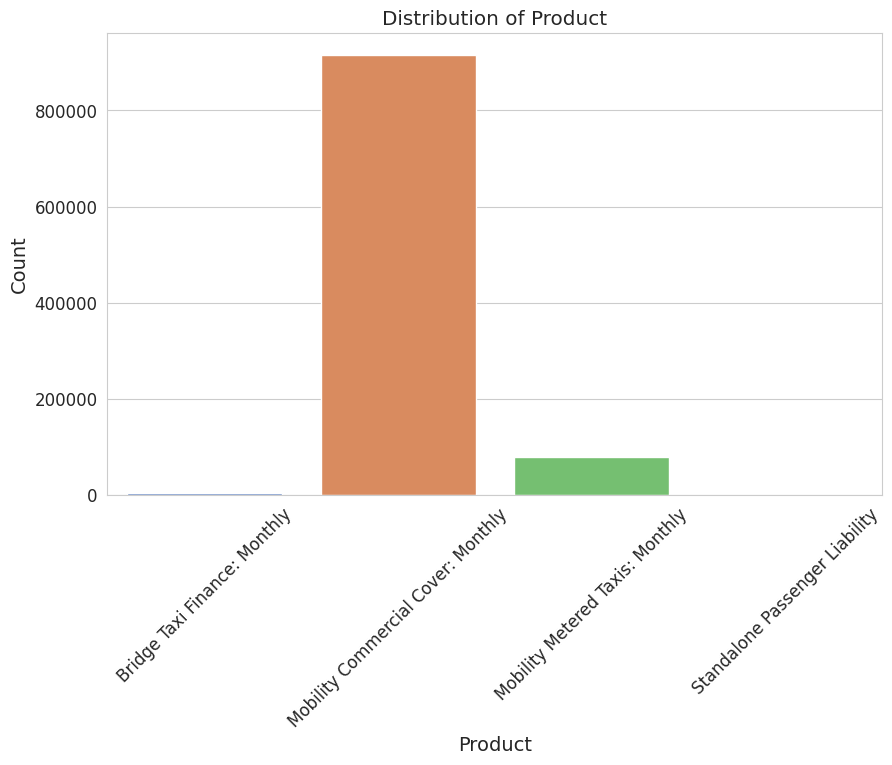

In [48]:
# --- Categorical Feature Distributions (Bar Charts) ---
# Select key categorical columns for frequency analysis
categorical_for_bar = ['Gender', 'Province', 'VehicleType', 'MaritalStatus', 'NumberOfDoors', 'LegalType', 'Product']
# Filter out columns that do not exist or have too many unique categories for meaningful bar plots
categorical_for_bar_present = [col for col in categorical_for_bar if col in df.columns and df[col].nunique() < 25] # Limit unique values for plot clarity

if categorical_for_bar_present:
    print("\nVisualizing Categorical Feature Distributions:")
    categorical_analyzer = UnivariateAnalyzer(CategoricalUnivariateAnalysis())
    for col in categorical_for_bar_present:
        categorical_analyzer.execute_analysis(df, col)
else:
    print("No specified categorical columns suitable for bar chart plotting found in DataFrame (or too many unique categories).")



**Interpretation of Univariate Analysis:**

- **Numerical Distributions:**
    - **Skewness:** Most financial variables (`TotalPremium`, `TotalClaims`, `CustomValueEstimate`) are typically right-skewed. This means a majority of policies/claims are small, but a few extremely large values exist. This impacts model choice (e.g., tree-based models handle skewness better, or transformations might be needed for linear models).
    - **Peaks/Modality:** Identify where the data concentrates (e.g., common premium bands, typical vehicle value ranges). Multiple peaks might suggest distinct customer segments.
    - **`RegistrationYear`:** Shows the age profile of vehicles in the portfolio, which can correlate with risk.
- **Categorical Distributions:**
    - **Dominant Categories:** Clearly identifies the most common categories (e.g., dominant provinces, gender distribution, popular vehicle types). These represent the largest customer segments for ACIS.
    - **Imbalance:** Note categories with very few counts. These "long-tail" categories can pose challenges for modeling and might need to be grouped or handled specially. For marketing, knowing the most common segments helps prioritize campaigns.

## **5. Bivariate & Multivariate Analysis**

This section explores relationships between two or more variables, focusing on how different segments impact the loss ratio, identifying correlations among numerical features, and analyzing temporal trends in claims and premiums. These analyses are crucial for identifying drivers of risk and profitability.

### **5.1. Segment-Wise Loss Ratio Analysis**

Beyond the overall portfolio loss ratio, understanding its variation across key segments (`Province`, `VehicleType`, `Gender`) is vital for granular business insights. This helps pinpoint high- and low-risk customer groups.

In [49]:
print("\n--- Segment-Wise Loss Ratio Analysis ---")

# Ensure required columns for segment-wise loss ratio calculation are present
required_segment_cols = ['TotalPremium', 'TotalClaims', 'PolicyID']

# Function to calculate and display segment loss ratio
def analyze_segment_loss_ratio(df_segment: pd.DataFrame, segment_column: str):
    if segment_column not in df_segment.columns or not all(col in df_segment.columns for col in required_segment_cols):
        print(f"Skipping Loss Ratio by {segment_column}: Required columns not found.")
        return

    print(f"\nLoss Ratio by {segment_column}:")
    segment_summary = df_segment.groupby(segment_column).agg(
        TotalPremium=('TotalPremium', 'sum'),
        TotalClaims=('TotalClaims', 'sum'),
        PolicyCount=('PolicyID', 'nunique')
    )
    # Handle division by zero for LossRatio
    segment_summary['LossRatio'] = segment_summary['TotalClaims'] / (segment_summary['TotalPremium'] + np.finfo(float).eps)
    segment_summary['LossRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    segment_summary['LossRatio'].fillna(0, inplace=True) # Set to 0 if premium was 0

    display(segment_summary.sort_values('LossRatio', ascending=False))

# Analyze Loss Ratio by Province
analyze_segment_loss_ratio(df, 'Province')

# Analyze Loss Ratio by VehicleType
analyze_segment_loss_ratio(df, 'VehicleType')

# Analyze Loss Ratio by Gender
analyze_segment_loss_ratio(df, 'Gender')




--- Segment-Wise Loss Ratio Analysis ---

Loss Ratio by Province:


/tmp/ipykernel_7438/3370173754.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = df_segment.groupby(segment_column).agg(
/tmp/ipykernel_7438/3370173754.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  segment_summary['LossRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_7438/3370173754.py:21

TotalPremium   TotalClaims  PolicyCount  LossRatio
Province                                                         
Gauteng        2.405377e+07  2.939415e+07         2578   1.222018
KwaZulu-Natal  1.320908e+07  1.430138e+07         1370   1.082693
Western Cape   9.806559e+06  1.038977e+07          947   1.059472
North West     7.490508e+06  5.920250e+06         1117   0.790367
Mpumalanga     2.836292e+06  2.044675e+06          382   0.720897
Free State     5.213632e+05  3.549223e+05           54   0.680758
Limpopo        1.537324e+06  1.016477e+06          181   0.661199
Eastern Cape   2.140104e+06  1.356427e+06          319   0.633813
Northern Cape  3.165581e+05  8.949051e+04           55   0.282699

/tmp/ipykernel_7438/3370173754.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = df_segment.groupby(segment_column).agg(



Loss Ratio by VehicleType:


/tmp/ipykernel_7438/3370173754.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  segment_summary['LossRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_7438/3370173754.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

TotalPremium   TotalClaims  PolicyCount  LossRatio
VehicleType                                                          
Heavy Commercial   4.609479e+05  7.504746e+05           72   1.628112
Medium Commercial  3.922746e+06  4.119867e+06          457   1.050251
Passenger Vehicle  5.664202e+07  5.937207e+07         6695   1.048198
Light Commercial   2.604975e+05  6.045250e+04           39   0.232066
Bus                5.824474e+04  7.996535e+03            6   0.137292

/tmp/ipykernel_7438/3370173754.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = df_segment.groupby(segment_column).agg(



Loss Ratio by Gender:


/tmp/ipykernel_7438/3370173754.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  segment_summary['LossRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_7438/3370173754.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

TotalPremium   TotalClaims  PolicyCount  LossRatio
Gender                                                           
Not specified  5.920275e+07  6.271410e+07         6601   1.059311
Male           1.580143e+06  1.396704e+06          232   0.883910
Female         3.044806e+05  2.502461e+05           35   0.821879

**Interpretation of Segment-Wise Loss Ratio:**

- **High-Risk Segments:** Identify segments (e.g., specific provinces, vehicle types, or genders) with significantly higher loss ratios than the portfolio average. These are areas where ACIS might be underpricing policies or facing higher claim frequencies/severities.
- **Low-Risk Segments:** Conversely, segments with consistently low loss ratios represent profitable areas. These could be targeted for increased marketing efforts or more competitive pricing to attract more customers.
- **Business Impact:** These insights are directly actionable. ACIS can use this information to adjust premiums, refine underwriting rules, or focus marketing campaigns to improve overall profitability. For instance, if 'Gauteng' has a high loss ratio, ACIS might investigate local factors or review pricing in that province.

### **5.2. Correlations and Associations**

This subsection explores linear relationships between numerical features through a correlation heatmap and visualizes pairwise relationships. We also examine associations between categorical variables using countplots or heatmaps.


--- Correlations and Associations ---

Visualizing Correlation Heatmap of Numerical Features:

--- Performing Multivariate Analysis ---


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

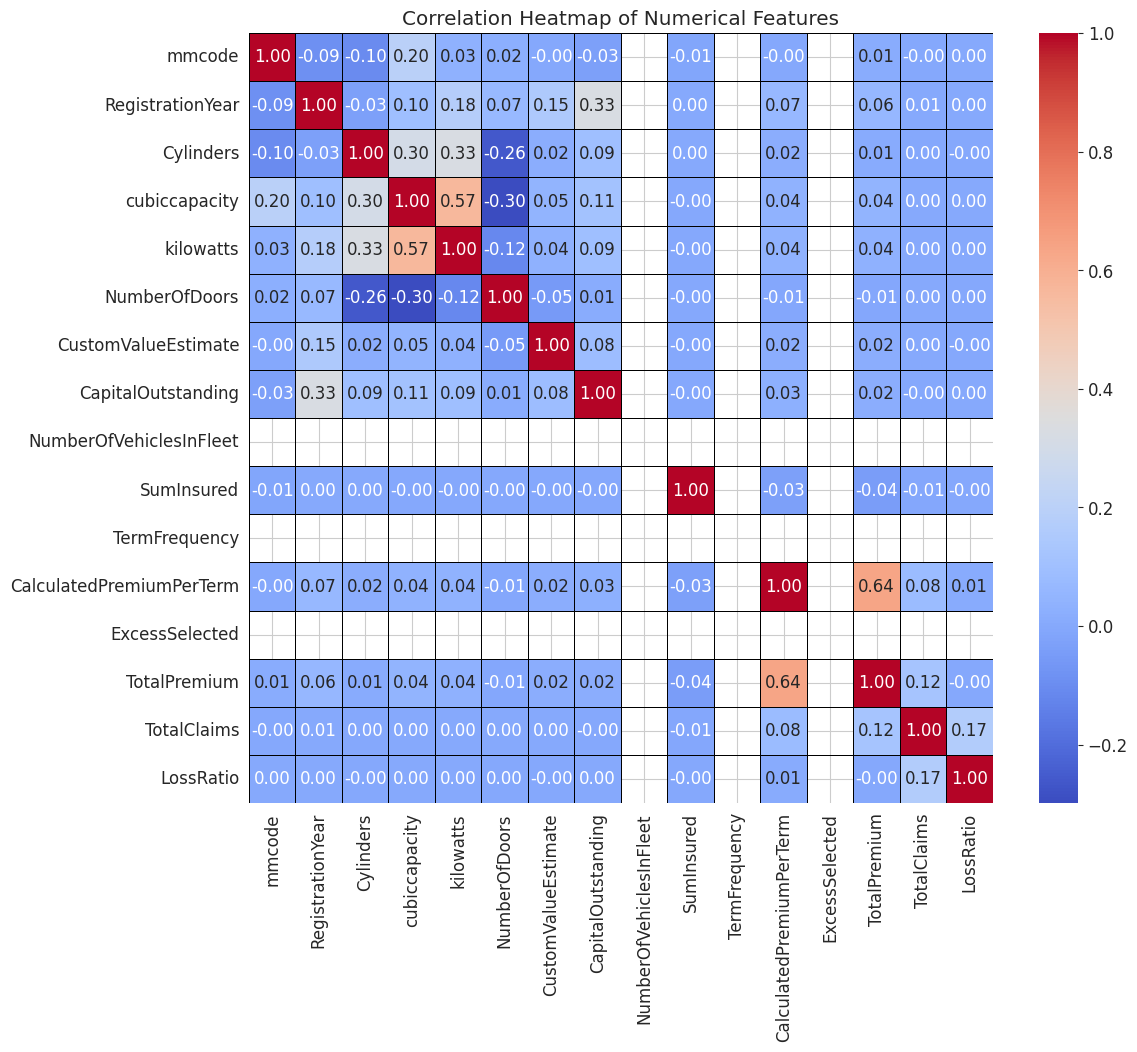

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

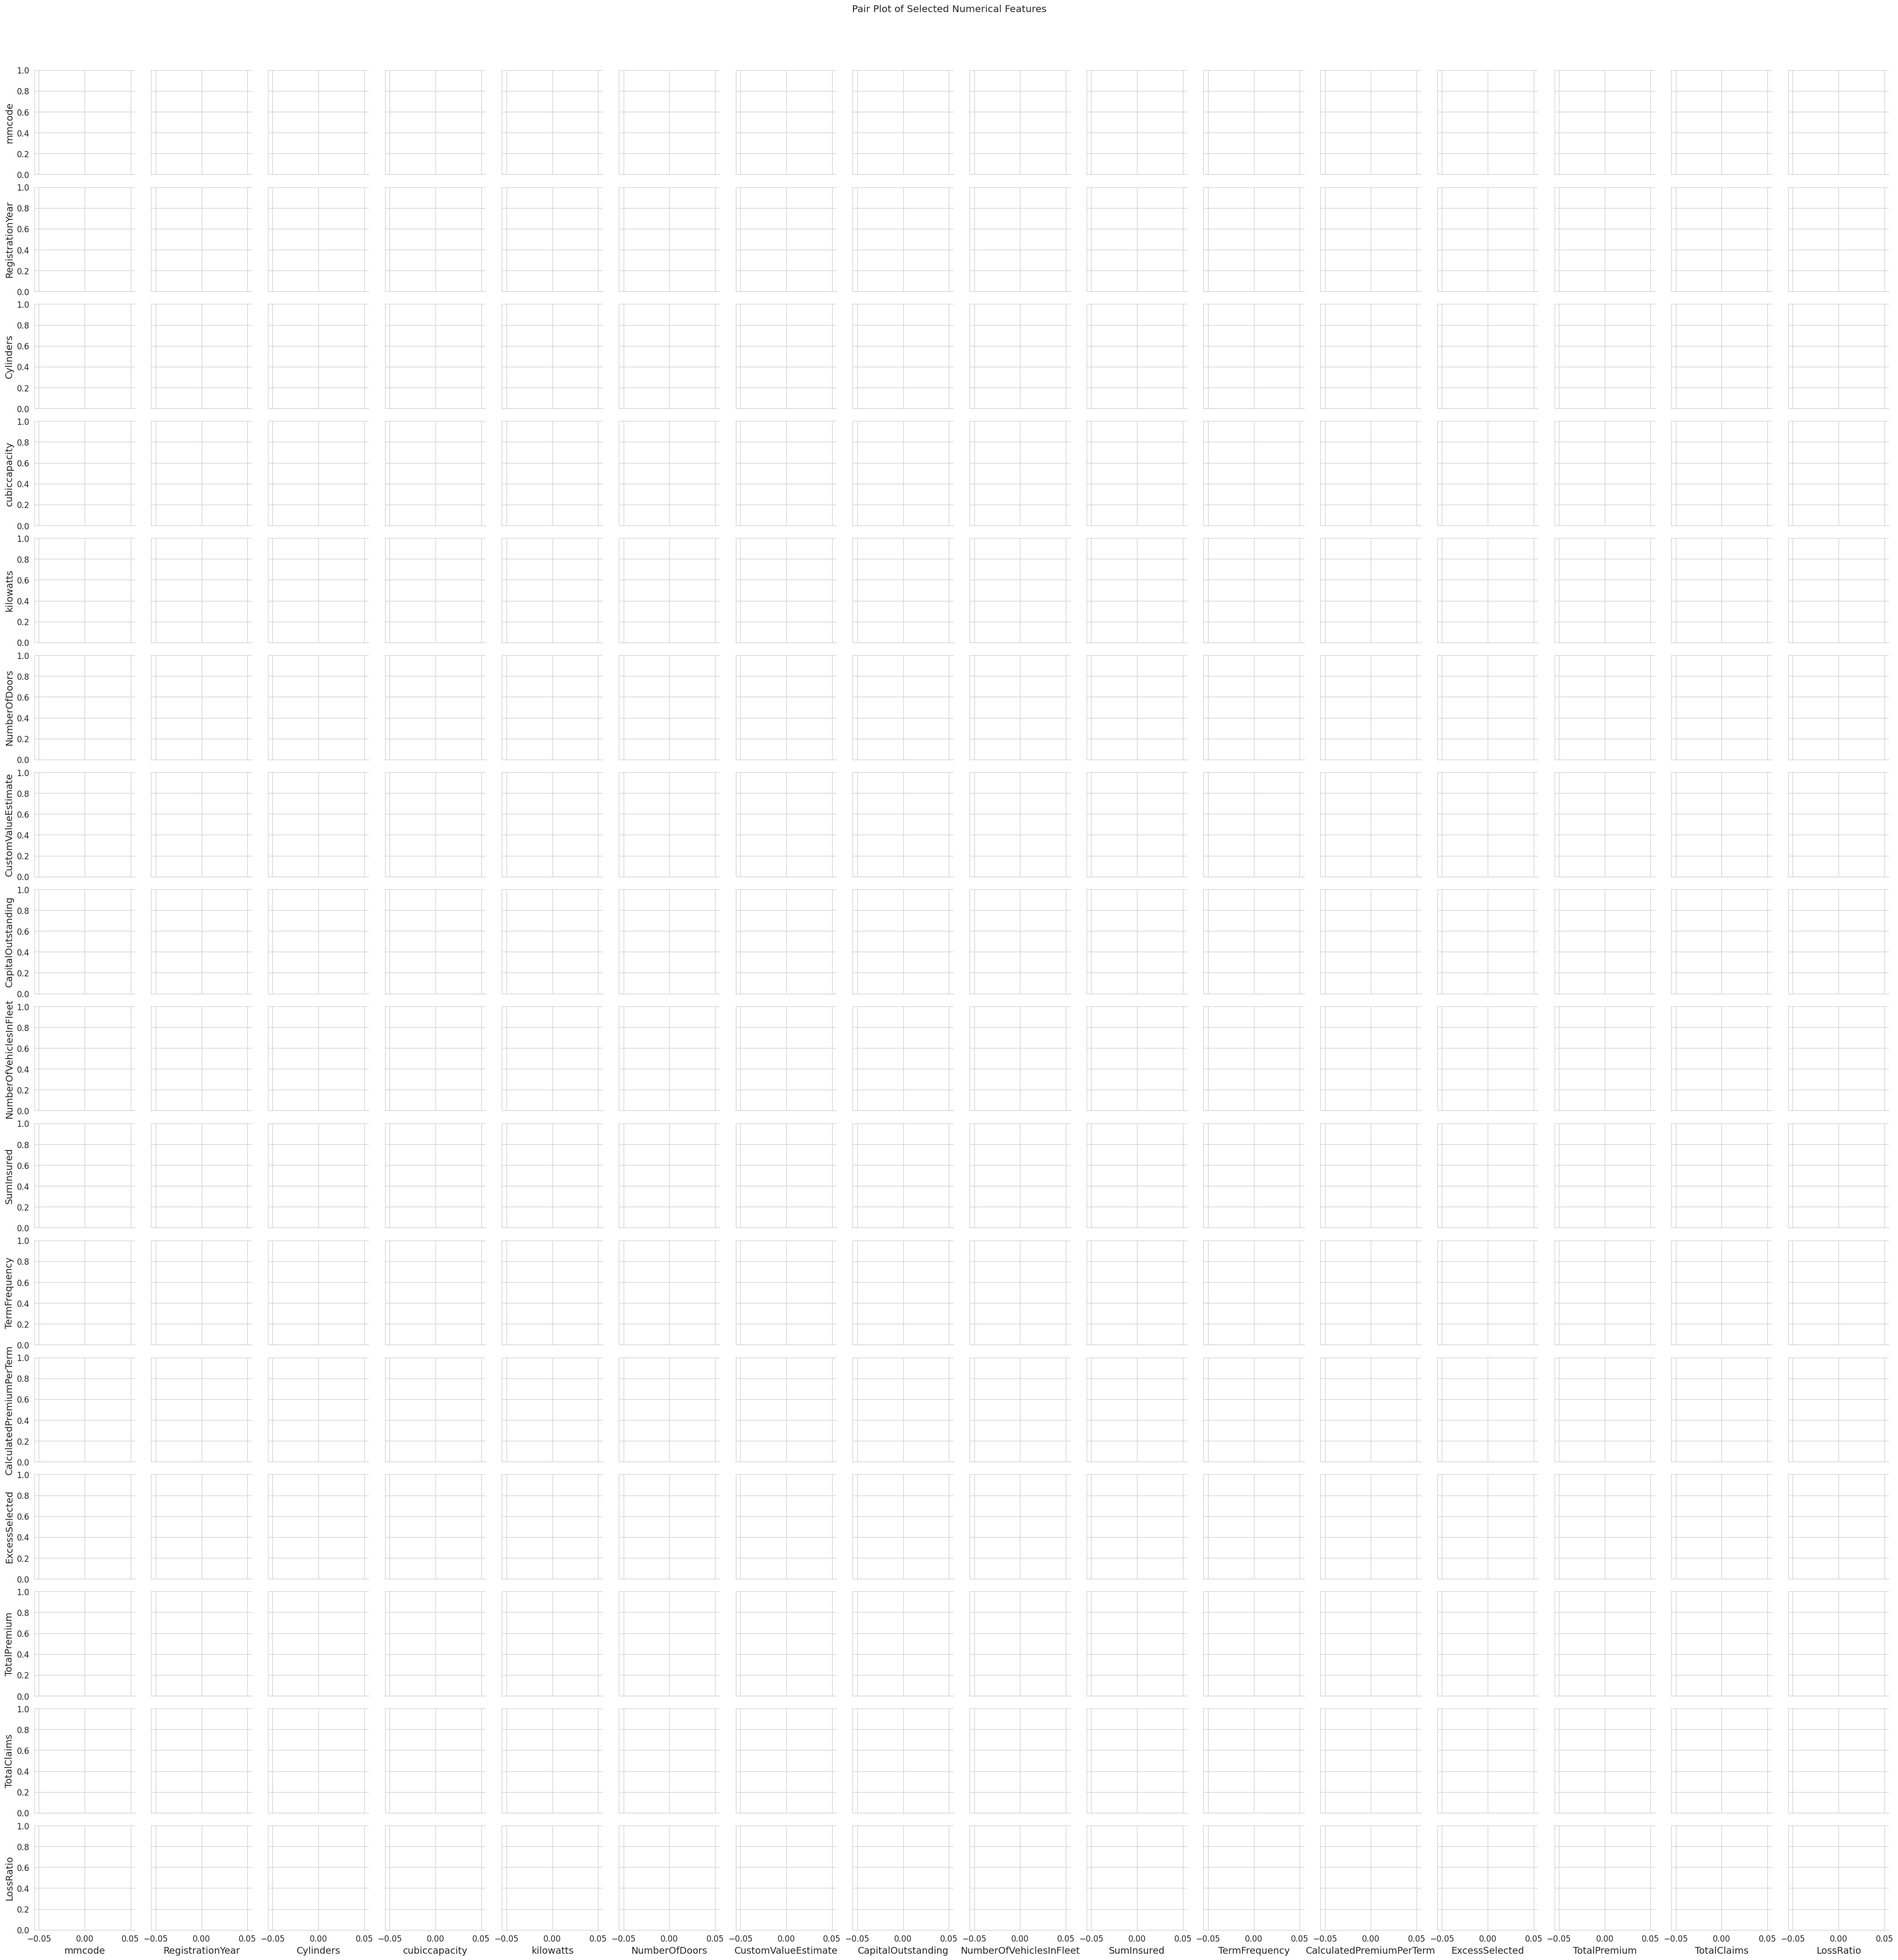

In [50]:
print("\n--- Correlations and Associations ---")

# --- Correlation Heatmap for Numerical Features (Multivariate Analysis) ---
print("\nVisualizing Correlation Heatmap of Numerical Features:")
# Initialize and execute the SimpleMultivariateAnalysis (for correlation heatmap)
multivariate_analyzer = SimpleMultivariateAnalysis()
multivariate_analyzer.analyze(df) # This calls generate_correlation_heatmap internally


Visualizing Pair Plot of Selected Key Numerical Features:

--- Performing Multivariate Analysis ---


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

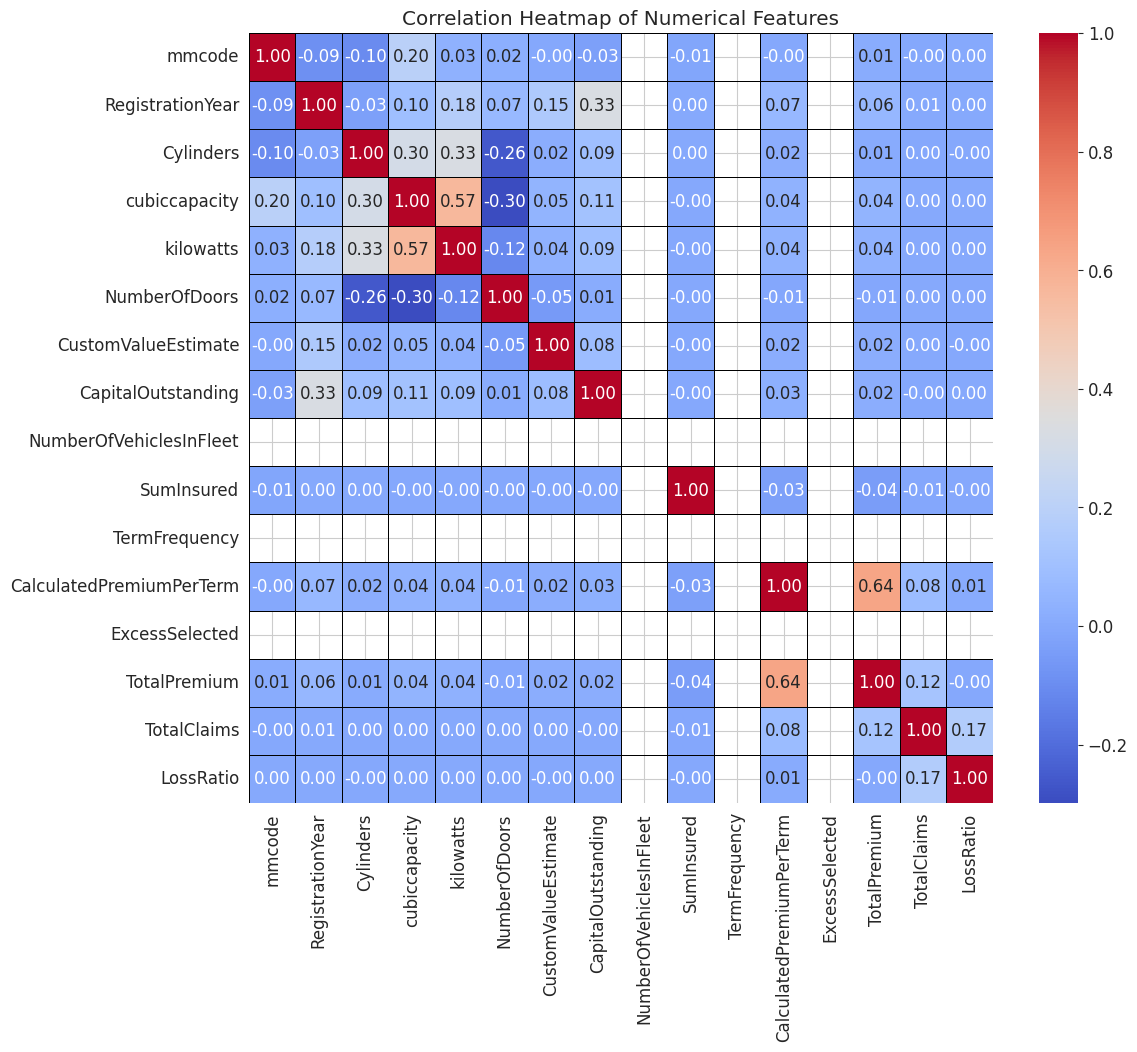

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

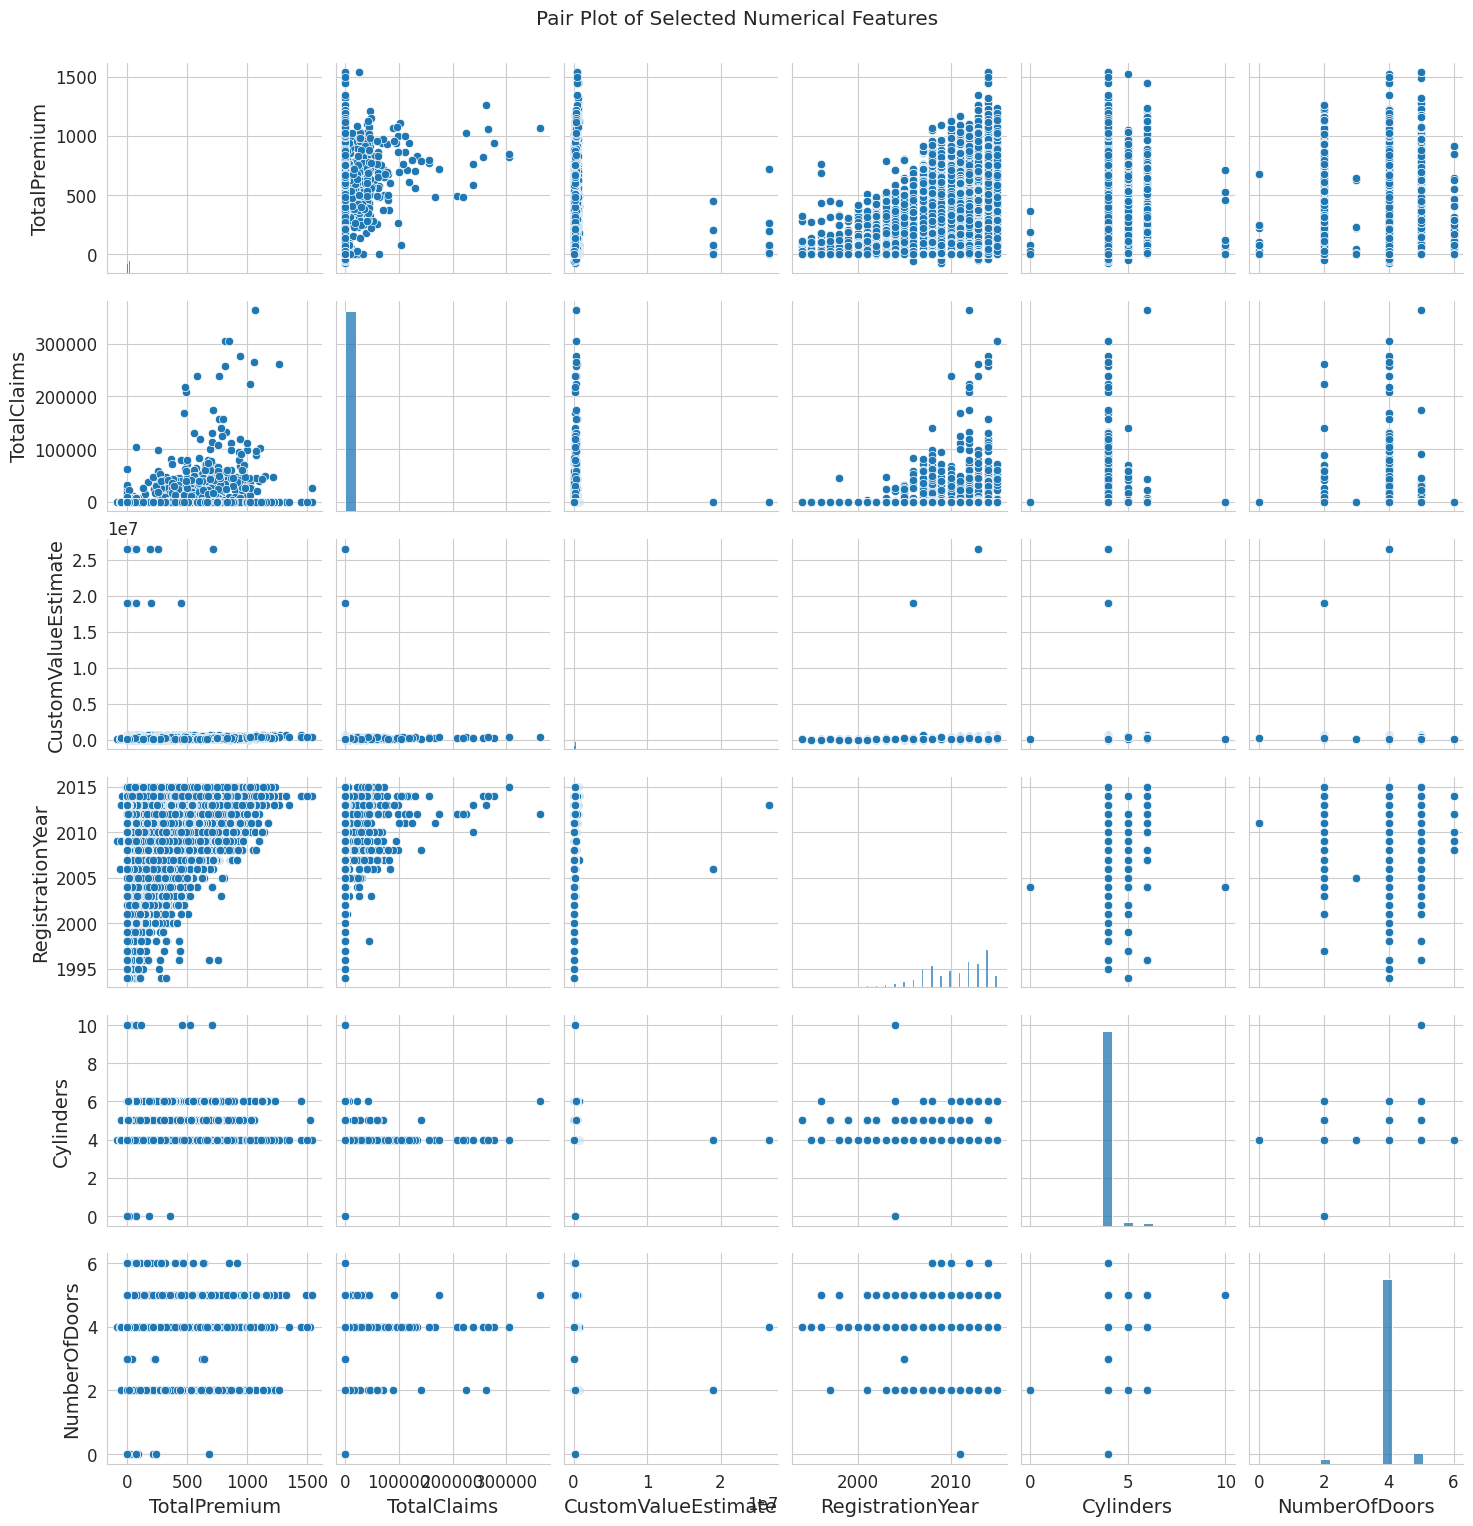

In [51]:
# --- Pair Plot for Selected Key Numerical Features (Multivariate Analysis) ---
print("\nVisualizing Pair Plot of Selected Key Numerical Features:")
selected_features_for_pairplot = [
    'TotalPremium', 'TotalClaims', 'CustomValueEstimate',
    'RegistrationYear', 'Cylinders', 'Kilowatts', 'NumberOfDoors'
]
multivariate_analyzer.analyze(df, features=selected_features_for_pairplot) # This calls generate_pairplot internally


In [52]:
# --- Bivariate Analysis Examples using BivariateAnalyzer ---
bivariate_analyzer = BivariateAnalyzer(NumericalVsNumericalAnalysis())



--- Bivariate: TotalPremium vs TotalClaims (Numerical vs Numerical) ---

--- Executing Bivariate Analysis: TotalPremium vs TotalClaims ---


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

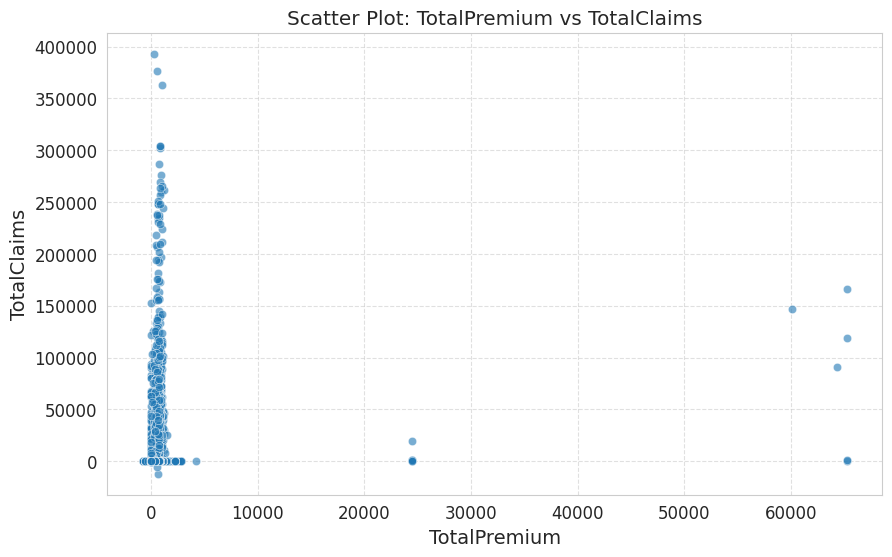

In [53]:
# Example: TotalPremium vs TotalClaims (Numerical vs Numerical)
print("\n--- Bivariate: TotalPremium vs TotalClaims (Numerical vs Numerical) ---")
bivariate_analyzer.execute_analysis(df, 'TotalPremium', 'TotalClaims')


--- Bivariate: Province vs TotalPremium (Categorical vs Numerical) ---

--- Executing Bivariate Analysis: Province vs TotalPremium ---


/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/bivariate_analysis.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = df.groupby(feature1)[feature2].median().sort_values(ascending=False).index
/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/bivariate_analysis.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature1, y=feature2, data=df, palette="viridis", order=order)
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font fami

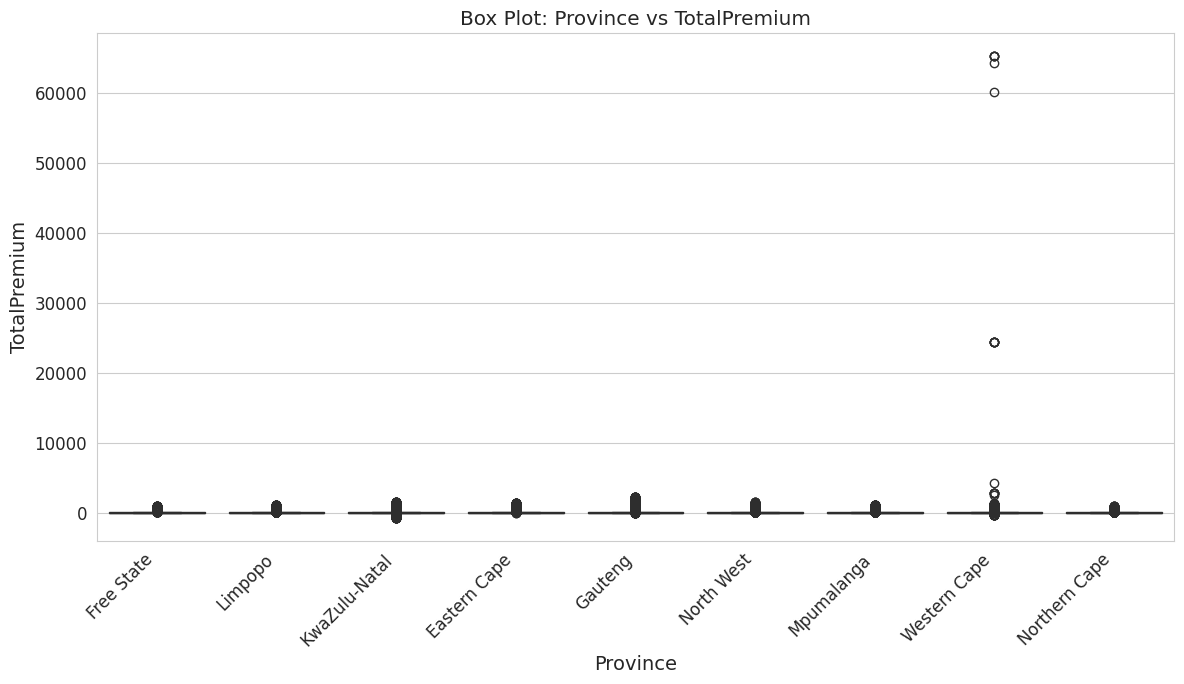

In [54]:
# Example: Province vs TotalPremium (Categorical vs Numerical)
print("\n--- Bivariate: Province vs TotalPremium (Categorical vs Numerical) ---")
bivariate_analyzer.set_strategy(CategoricalVsNumericalAnalysis())
bivariate_analyzer.execute_analysis(df, 'Province', 'TotalPremium')


--- Bivariate: VehicleType vs TotalClaims (Categorical vs Numerical) ---

--- Executing Bivariate Analysis: VehicleType vs TotalClaims ---


/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/bivariate_analysis.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = df.groupby(feature1)[feature2].median().sort_values(ascending=False).index
/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/bivariate_analysis.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=feature1, y=feature2, data=df, palette="viridis", order=order)
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font fami

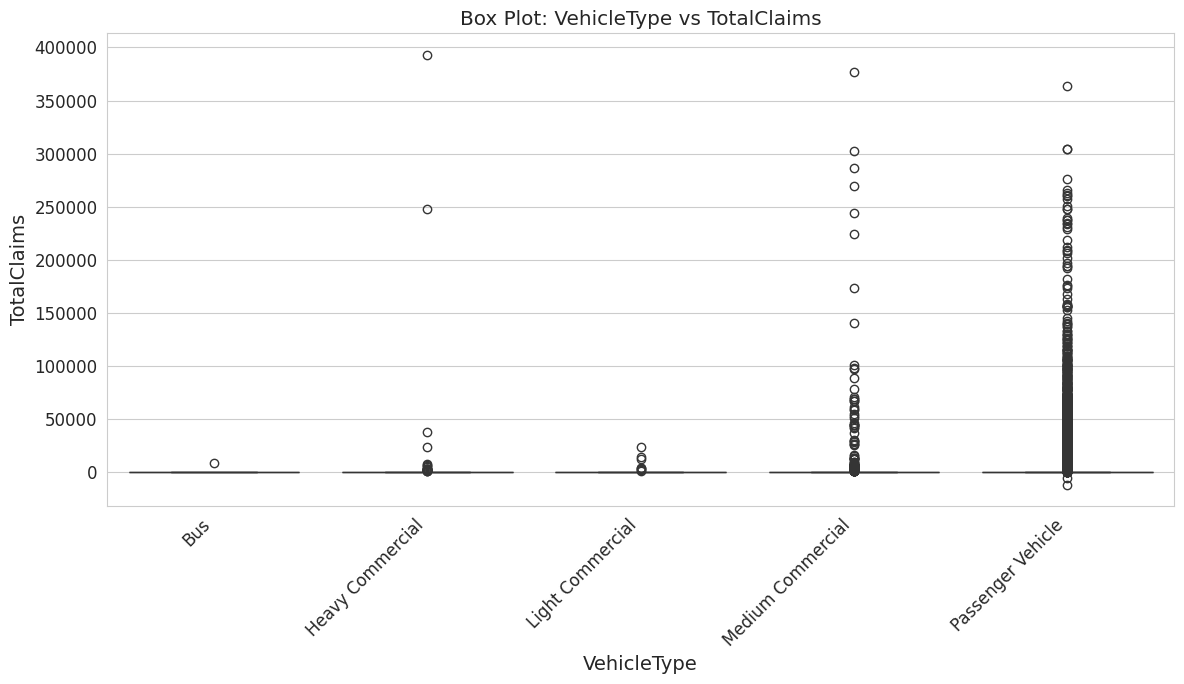

In [55]:
# Example: VehicleType vs TotalClaims (Categorical vs Numerical)
print("\n--- Bivariate: VehicleType vs TotalClaims (Categorical vs Numerical) ---")
bivariate_analyzer.execute_analysis(df, 'VehicleType', 'TotalClaims')


--- Bivariate: Gender vs VehicleType (Categorical vs Categorical) ---

--- Executing Bivariate Analysis: Gender vs VehicleType ---


findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

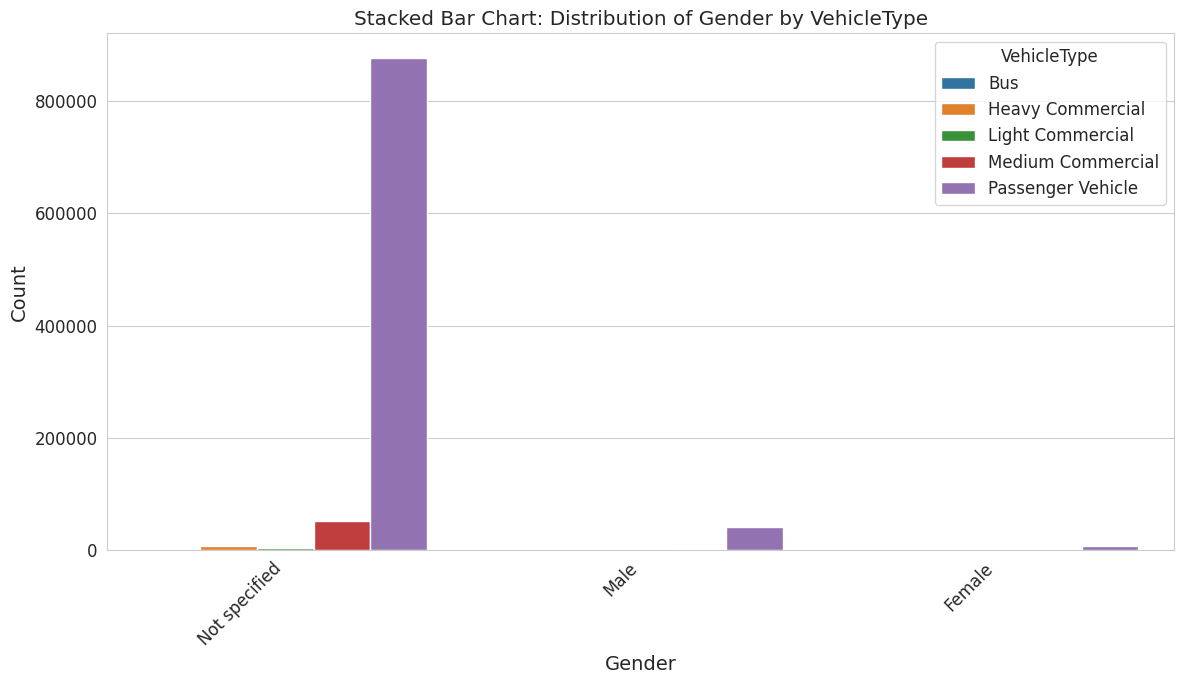

In [56]:
# Example: Gender vs VehicleType (Categorical vs Categorical)
print("\n--- Bivariate: Gender vs VehicleType (Categorical vs Categorical) ---")
bivariate_analyzer.set_strategy(CategoricalVsCategoricalAnalysis())
bivariate_analyzer.execute_analysis(df, 'Gender', 'VehicleType')

In [57]:
# Example: Make vs Bodytype (Categorical vs Categorical - potentially showing heatmap)
print("\n--- Bivariate: Make vs Bodytype (Categorical vs Categorical - could be heatmap) ---")
bivariate_analyzer.execute_analysis(df, 'Make', 'Bodytype')


--- Bivariate: Make vs Bodytype (Categorical vs Categorical - could be heatmap) ---

--- Executing Bivariate Analysis: Make vs Bodytype ---
Error: One or both features ('Make', 'Bodytype') not found in the DataFrame.


**Interpretation of Correlations and Associations:**

- **Correlation Heatmap:**
    - **Strength and Direction:** Coefficients close to `+1` (strong positive) or `1` (strong negative) indicate strong linear relationships. Values close to `0` indicate weak or no linear relationship.
    - **Key Relationships:** For instance, a strong positive correlation between `CustomValueEstimate` and `TotalPremium` is expected, as more valuable vehicles typically incur higher premiums. The correlation between `TotalPremium` and `TotalClaims` is crucial: a positive correlation implies that higher premiums are indeed associated with higher claim payouts, which is fundamental to insurance risk.
    - **Insights for Modeling:** Strong correlations identify features that are potentially good predictors or might exhibit multicollinearity (which some models are sensitive to). Weak or unexpected correlations can highlight areas for further investigation or features that might be less impactful.
- **Pair Plots:** These plots provide a visual matrix of scatter plots for each numerical pair and histograms for individual features. They help identify non-linear relationships, clusters, and distributions that a simple correlation coefficient might miss.
- **Categorical vs. Numerical (Box Plots):** Box plots for `Province` vs. `TotalPremium` or `Gender` vs. `TotalClaims` reveal how the *distribution* of a numerical variable changes across different categories. This can clearly show if certain provinces or genders have higher average premiums or claims, or if their data is more spread out.
- **Categorical vs. Categorical (Count/Heatmap):** These plots show the joint frequency of two categorical variables. For example, `Gender` vs. `VehicleType` might reveal if certain vehicle types are disproportionately owned or claimed by a particular gender. Heatmaps are especially useful for visualizing relationships between categories when there are many unique combinations.

### **5.3. Temporal Trend Analysis**

Understanding how key metrics evolve over time is crucial for assessing stability, identifying seasonality, and evaluating the impact of past business decisions. We'll analyze monthly trends for `TotalPremium`, `TotalClaims`, `LossRatio`, and `ClaimFrequency`.


--- Temporal Trend Analysis ---

--- Executing Temporal Analysis for 'TransactionMonth' ---


/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/temporal_analysis.py:88: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  aggregation_dict[metric] = 'sum' # Default to sum for numerical metrics
/home/micha/Downloads/course/10-accademy/week-3/Insurance-Risk-Analytics-and-Predictive-Modeling/src/utils/eda/temporal_analysis.py:93: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  if 'TotalPremium' in monthly_summary.colu


Monthly Aggregated Summary:
                  TotalPremium   TotalClaims  PolicyID  LossRatio  \
TransactionMonth                                                    
2013-10-31        3.710635e+02  0.000000e+00         5   0.000000   
2013-11-30        2.130747e+04  5.058508e+04        78   2.374054   
2013-12-31        4.248475e+04  9.283386e+03       100   0.218511   
2014-01-31        5.408520e+04  1.243686e+04       126   0.229949   
2014-02-28        6.078844e+04  6.298931e+04       148   1.036205   
2014-03-31        9.857719e+04  3.227850e+05       264   3.274439   
2014-04-30        2.342743e+05  3.068636e+05       474   1.309847   
2014-05-31        3.759117e+05  5.180427e+05       659   1.378097   
2014-06-30        4.862194e+05  5.045364e+05       826   1.037672   
2014-07-31        6.092661e+05  4.289822e+05      1036   0.704097   
2014-08-31        9.074381e+05  6.934197e+05      1318   0.764151   
2014-09-30        1.237522e+06  9.089024e+05      1698   0.734454   
2014-

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

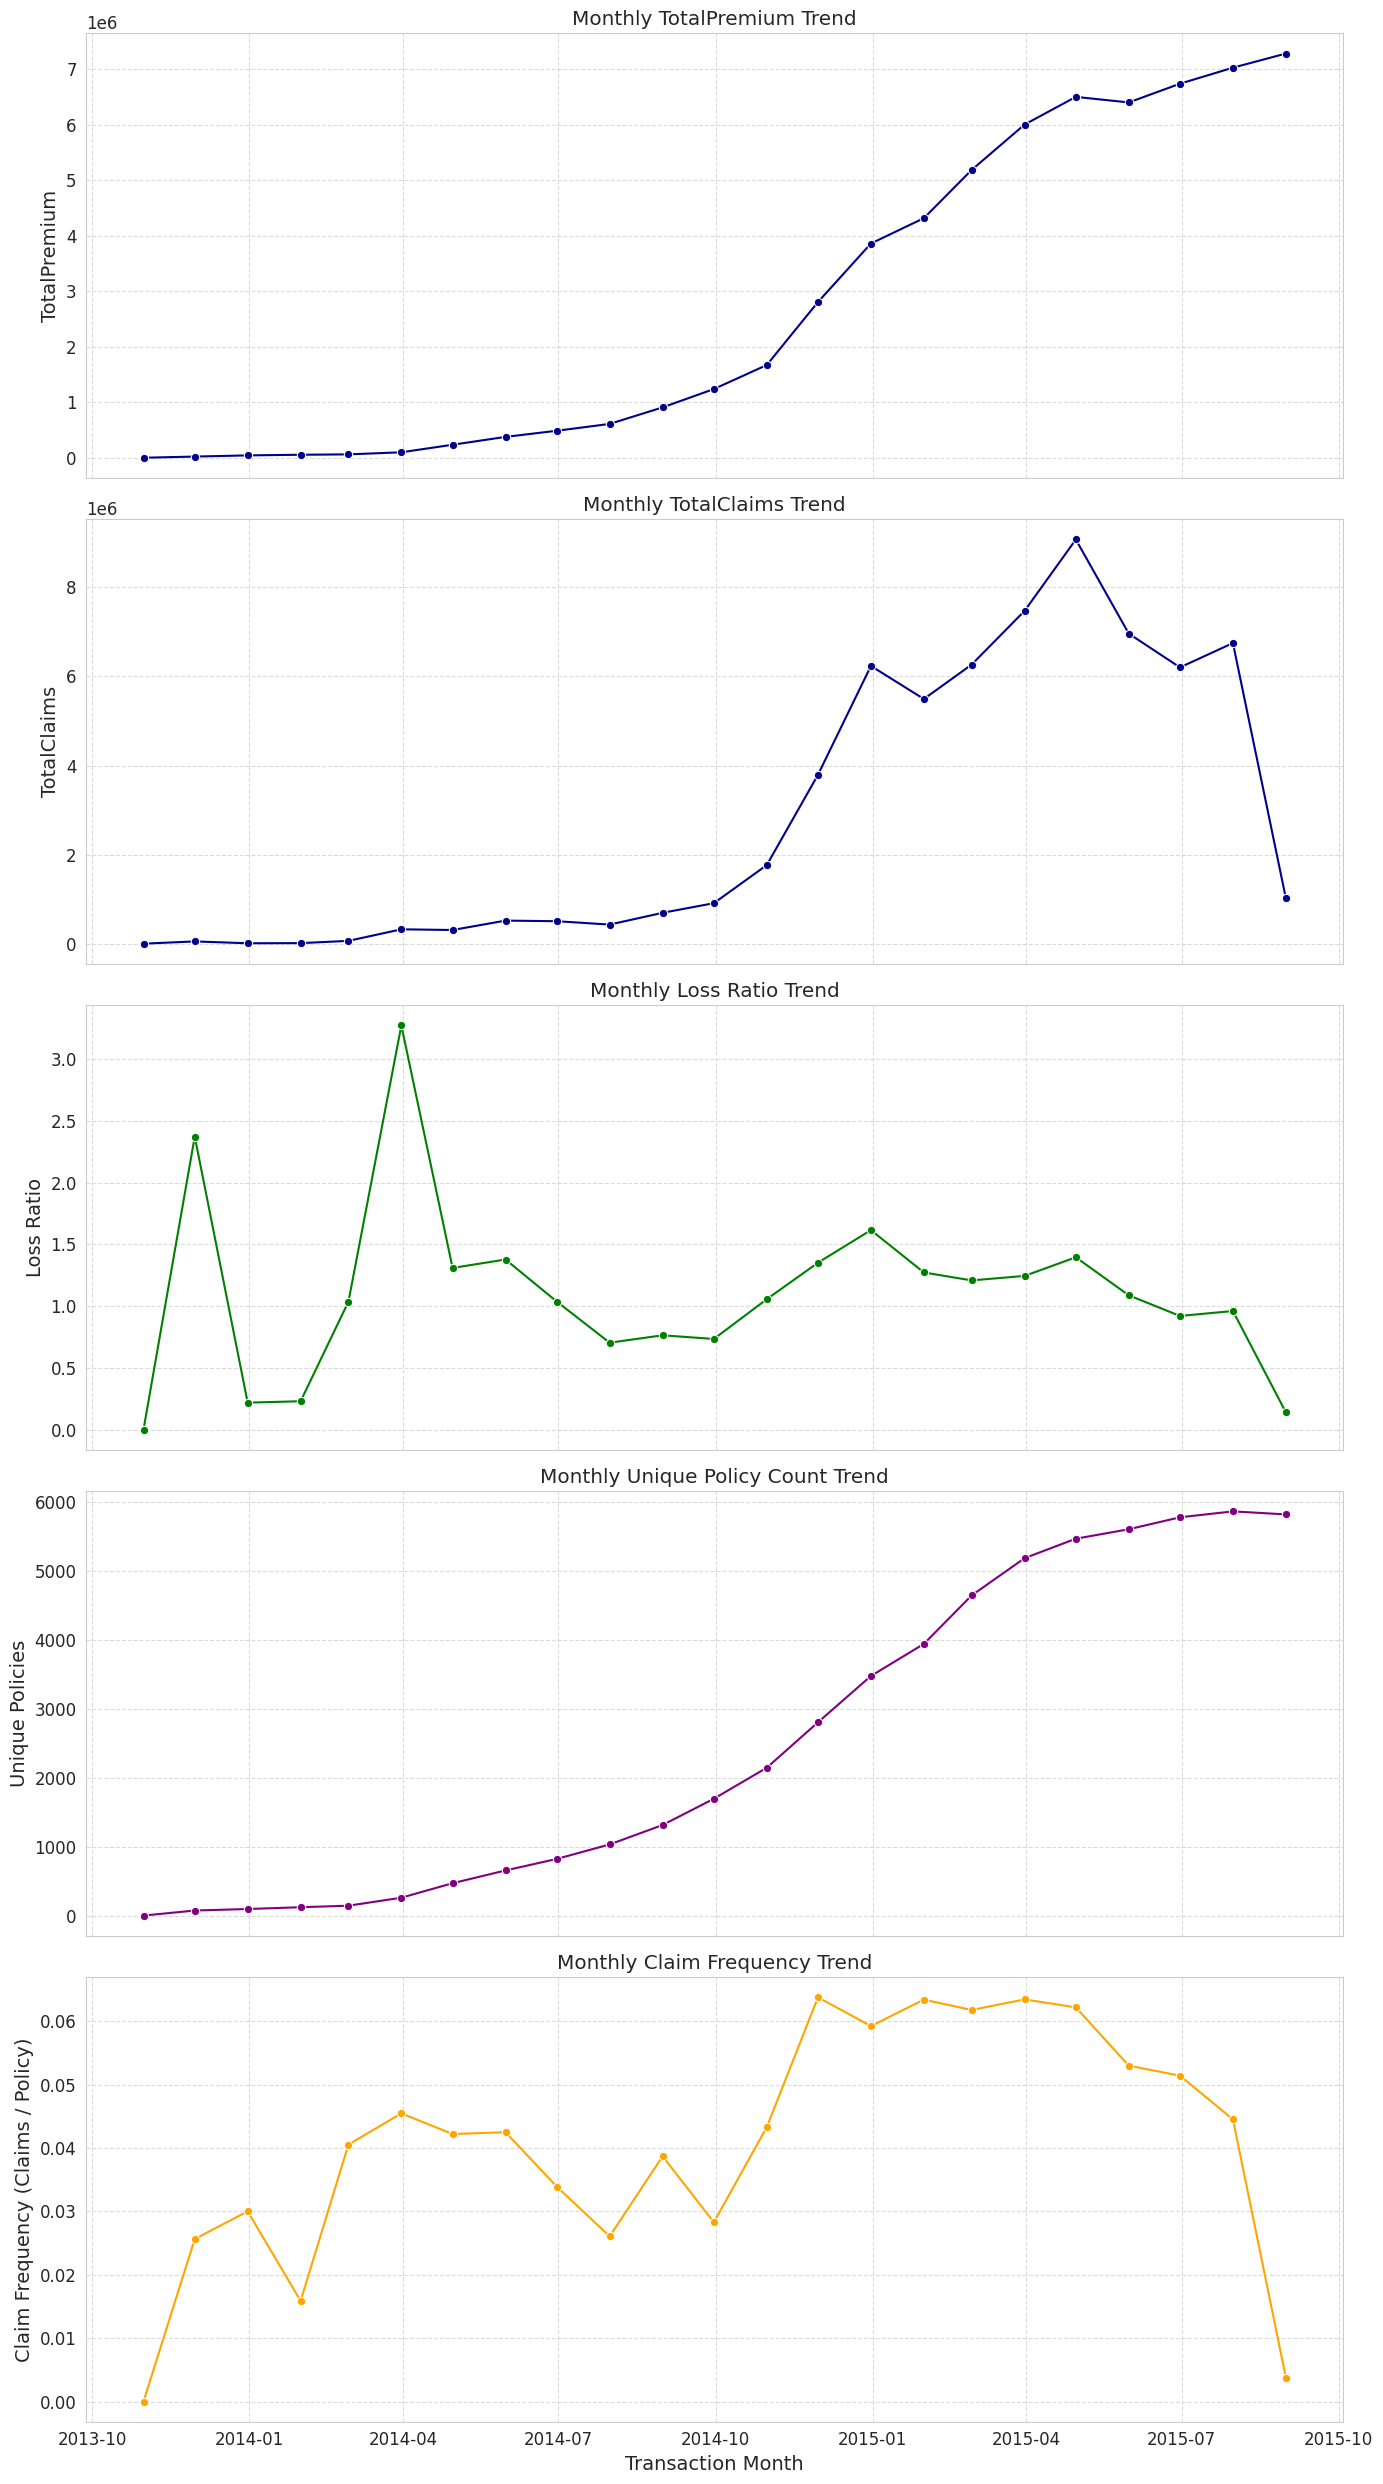

In [58]:
print("\n--- Temporal Trend Analysis ---")
temporal_analyzer = TemporalAnalyzer(MonthlyTrendAnalysis())

# Define the numerical metrics to be plotted as trends.
# Ensure 'TotalPremium', 'TotalClaims', and 'PolicyID' are also present for derived metrics.
metrics_to_plot_trends = ['TotalPremium', 'TotalClaims']

# Execute the temporal analysis if 'TransactionMonth' column exists and is of datetime type
if 'TransactionMonth' in df.columns and pd.api.types.is_datetime64_any_dtype(df['TransactionMonth']):
    temporal_analyzer.execute_analysis(df, 'TransactionMonth', metrics_to_plot_trends)
else:
    print("Skipping temporal analysis: 'TransactionMonth' column not found or not in datetime format. Please ensure preprocessing correctly converted it.")


**Interpretation of Temporal Trends:**

- **Overall Movement:** Observe if total premiums, total claims, loss ratio, and claim frequency are generally increasing, decreasing, or stable over the observed period (Feb 2014 - Aug 2015).
- **Seasonality/Cyclical Patterns:** Look for recurring patterns within a year (e.g., claims peaking in certain months due to weather, holidays, etc.). Identifying seasonality is important for forecasting and resource allocation (e.g., staffing for claims processing).
- **Anomalies/Spikes:** Any sudden, unexplained spikes or drops warrant further investigation. These could be due to major events (e.g., severe weather events, policy changes by ACIS, market disruptions) that significantly impacted the portfolio.
- **Business Impact:** Understanding these trends helps ACIS:
    - Forecast future premiums and claims.
    - Evaluate the effectiveness of past pricing changes or marketing campaigns.
    - Proactively manage claims operations based on expected peaks.
    - Inform long-term business strategy.

### **5.4. Vehicle Performance Analysis**

This analysis delves into the performance of different vehicle makes and models in terms of claim severity. This insight is critical for refining underwriting rules and adjusting premiums based on the inherent risk profiles of various vehicles.

In [59]:
print("\n--- Vehicle Performance Analysis (Average Claim Amount by Make/Model) ---")

# Calculate average claims by Make and Model, focusing only on policies that actually incurred claims (> 0)
claims_df_for_vehicle_perf = df[df['TotalClaims'] > 0].copy()

# Ensure 'Make', 'Model', and 'PolicyID' columns exist for this analysis
if all(col in claims_df_for_vehicle_perf.columns for col in ['Make', 'Model', 'PolicyID', 'TotalClaims']):
    make_model_claims = claims_df_for_vehicle_perf.groupby(['Make', 'Model']).agg(
        AvgClaimAmount=('TotalClaims', 'mean'),
        ClaimCount=('PolicyID', 'count') # Number of claims for each Make-Model combination
    ).reset_index()

    # Filter for Make/Models with a reasonable number of claims to ensure statistical reliability
    min_claims_for_analysis = 10 # Set a minimum threshold for meaningful averages
    make_model_claims_filtered = make_model_claims[make_model_claims['ClaimCount'] >= min_claims_for_analysis].copy()

    if not make_model_claims_filtered.empty:
        print(f"\nTop 10 Vehicle Make/Models by Average Claim Amount (min {min_claims_for_analysis} claims):")
        display(make_model_claims_filtered.sort_values('AvgClaimAmount', ascending=False).head(10))

        print(f"\nBottom 10 Vehicle Make/Models by Average Claim Amount (min {min_claims_for_analysis} claims):")
        display(make_model_claims_filtered.sort_values('AvgClaimAmount', ascending=True).head(10))

        # Visualization: Average Claim Amount by Top N Vehicle Makes
        # This plot helps visualize how claim severity varies across different manufacturers.
        top_n_makes_avg_claim = make_model_claims_filtered.groupby('Make')['AvgClaimAmount'].mean().nlargest(10).index
        df_top_makes_claims_plot = make_model_claims_filtered[make_model_claims_filtered['Make'].isin(top_n_makes_avg_claim)].copy()

        if not df_top_makes_claims_plot.empty:
            plt.figure(figsize=(14, 8))
            # Bar plot showing average claim amount, colored by Model to see within-Make variation
            sns.barplot(data=df_top_makes_claims_plot.sort_values('AvgClaimAmount', ascending=False),
                        x='AvgClaimAmount', y='Make', hue='Model', palette='coolwarm', dodge=False)
            plt.title(f'Average Claim Amount by Top 10 Vehicle Makes (min {min_claims_for_analysis} claims per Make-Model)')
            plt.xlabel('Average Claim Amount')
            plt.ylabel('Vehicle Make')
            plt.tight_layout()
            plt.show()
        else:
            print("No sufficient data for plotting top vehicle makes after filtering.")
    else:
        print("No sufficient make/model data with claims for filtered analysis after applying minimum claim count.")
else:
    print("Skipping vehicle performance analysis: 'Make', 'Model', 'PolicyID', or 'TotalClaims' columns not found, or no claims present in the data.")



--- Vehicle Performance Analysis (Average Claim Amount by Make/Model) ---
Skipping vehicle performance analysis: 'Make', 'Model', 'PolicyID', or 'TotalClaims' columns not found, or no claims present in the data.


**Interpretation of Vehicle Performance Analysis:**

- **High-Cost Vehicles:** The "Top 10" list highlights vehicle `Make`/`Model` combinations associated with the highest average claim payouts. This could be due to higher repair costs, more advanced technology (costly to fix), or a propensity for more severe accidents. This information is crucial for accurately pricing policies for these vehicles.
- **Low-Cost Vehicles:** Conversely, the "Bottom 10" list indicates vehicles with lower average claim amounts, potentially representing lower inherent risk in terms of claim severity.
- **Actionable Advice:** ACIS can leverage this analysis to:
    - **Adjust Premiums:** Implement differential pricing strategies for specific makes/models based on their average claim severity.
    - **Underwriting:** Create stricter underwriting guidelines for high-cost vehicles or offer incentives for low-cost ones.
    - **Product Development:** Consider offering specialized products or benefits for vehicle types that consistently show low claim severity.

## **6. Outlier Detection**

Outliers are data points that significantly deviate from other observations. In insurance data, extremely high claims or asset values can be legitimate but unusual, or they might be data entry errors. Detecting and understanding them is crucial as they can heavily influence statistical analyses and machine learning models.


--- Outlier Detection for Key Numerical Features ---

**Analyzing Outliers in TotalClaims (claims > 0):**

--- Outlier Analysis for 'TotalClaims' (IQR Method) ---
  Q1: 1680.73
  Q3: 30480.99
  IQR: 28800.26
  Lower Bound: -41519.67
  Upper Bound: 73681.39
  Number of outliers detected: 188

Sample of detected outliers for 'TotalClaims':
        UnderwrittenCoverID  PolicyID TransactionMonth IsVATRegistered  \
451249                72315      4239       2014-12-01           False   
601844               139197     12164       2015-03-01           False   
818316               124787     10516       2015-05-01           False   
738349               155659     13767       2015-05-01           False   
173451               179198     14512       2015-05-01           False   

       Citizenship        LegalType Title Language                 Bank  \
451249                   Individual    Mr  English  First National Bank   
601844                   Individual    Mr  English        Standa

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

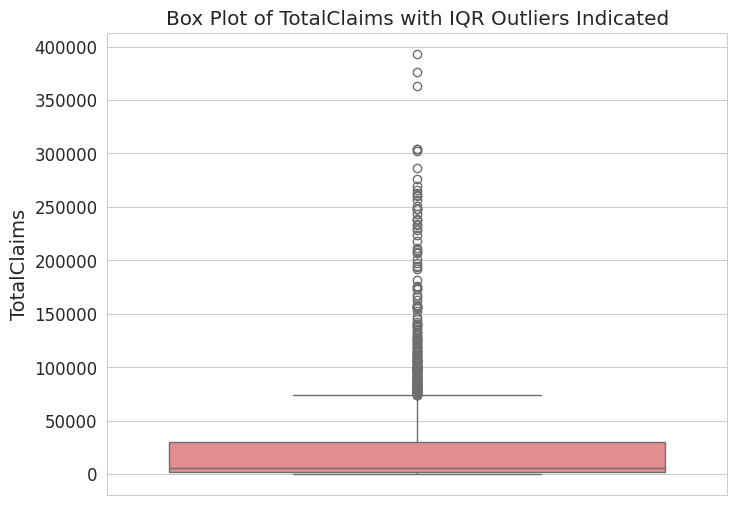


**Analyzing Outliers in TotalPremium:**

--- Outlier Analysis for 'TotalPremium' (IQR Method) ---
  Q1: 0.00
  Q3: 21.93
  IQR: 21.93
  Lower Bound: -32.89
  Upper Bound: 54.82
  Number of outliers detected: 209042

Sample of detected outliers for 'TotalPremium':
        UnderwrittenCoverID  PolicyID TransactionMonth IsVATRegistered  \
763423               131744      7258       2015-03-01           False   
789370               131744      7258       2015-01-01           False   
789458               131744      7258       2015-04-01           False   
829420               131744      7258       2015-02-01           False   
851081               110755      7258       2014-11-01           False   

       Citizenship        LegalType Title Language       Bank  \
763423              Private company    Mr  English  ABSA Bank   
789370              Private company    Mr  English  ABSA Bank   
789458              Private company    Mr  English  ABSA Bank   
829420              Private co

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

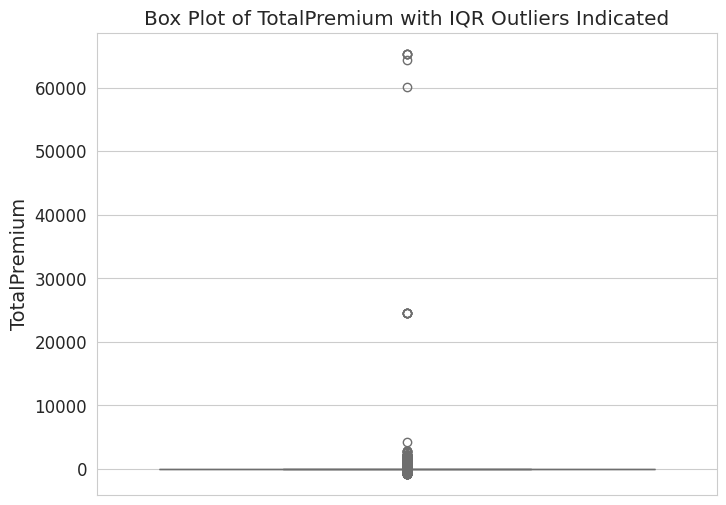


**Analyzing Outliers in CustomValueEstimate:**

--- Outlier Analysis for 'CustomValueEstimate' (IQR Method) ---
  Q1: 135000.00
  Q3: 280000.00
  IQR: 145000.00
  Lower Bound: -82500.00
  Upper Bound: 497500.00
  Number of outliers detected: 1785

Sample of detected outliers for 'CustomValueEstimate':
      UnderwrittenCoverID  PolicyID TransactionMonth IsVATRegistered  \
8775               153964     12284       2015-04-01           False   
8776               153960     12284       2015-04-01           False   
8777               153960     12284       2015-06-01           False   
8778               153960     12284       2015-08-01           False   
8779               153959     12284       2015-03-01           False   

     Citizenship   LegalType Title Language Bank AccountType  ...  \
8775              Individual    Mr  English  NaN         NaN  ...   
8776              Individual    Mr  English  NaN         NaN  ...   
8777              Individual    Mr  English  NaN        

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

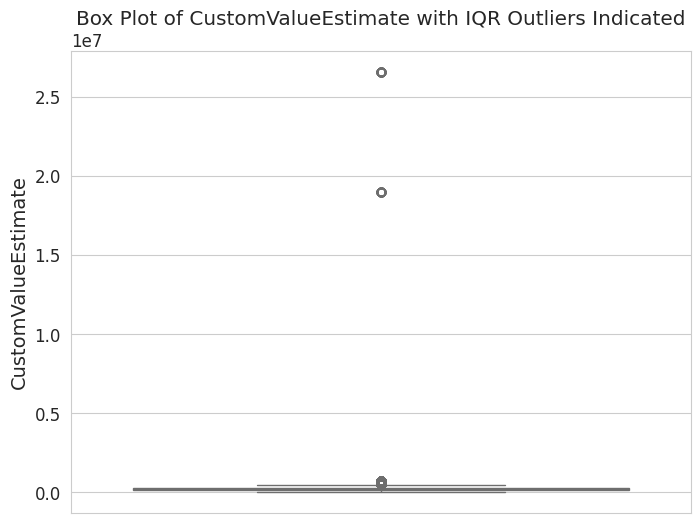


**Analyzing Outliers in CalculatedPremiumPerTerm:**

--- Outlier Analysis for 'CalculatedPremiumPerTerm' (IQR Method) ---
  Q1: 3.22
  Q3: 90.00
  IQR: 86.78
  Lower Bound: -126.94
  Upper Bound: 220.16
  Number of outliers detected: 175508

Sample of detected outliers for 'CalculatedPremiumPerTerm':
        UnderwrittenCoverID  PolicyID TransactionMonth IsVATRegistered  \
763422               131744      7258       2014-12-01           False   
763423               131744      7258       2015-03-01           False   
763424               131744      7258       2015-05-01           False   
763425               131744      7258       2015-07-01           False   
789370               131744      7258       2015-01-01           False   

       Citizenship        LegalType Title Language       Bank  \
763422              Private company    Mr  English  ABSA Bank   
763423              Private company    Mr  English  ABSA Bank   
763424              Private company    Mr  English  ABSA 

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

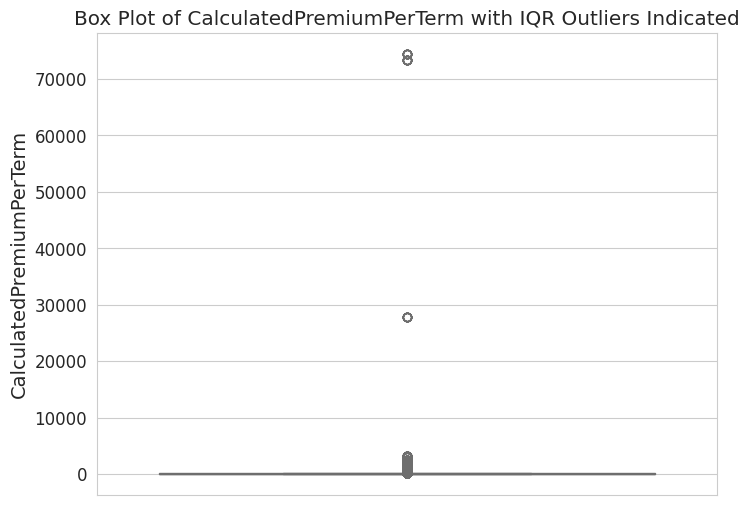


**Analyzing Outliers in SumInsured:**

--- Outlier Analysis for 'SumInsured' (IQR Method) ---
  Q1: 5000.00
  Q3: 250000.00
  IQR: 245000.00
  Lower Bound: -362500.00
  Upper Bound: 617500.00
  Number of outliers detected: 104294

Sample of detected outliers for 'SumInsured':
        UnderwrittenCoverID  PolicyID TransactionMonth IsVATRegistered  \
763422               131744      7258       2014-12-01           False   
763423               131744      7258       2015-03-01           False   
763424               131744      7258       2015-05-01           False   
763425               131744      7258       2015-07-01           False   
789370               131744      7258       2015-01-01           False   

       Citizenship        LegalType Title Language       Bank  \
763422              Private company    Mr  English  ABSA Bank   
763423              Private company    Mr  English  ABSA Bank   
763424              Private company    Mr  English  ABSA Bank   
763425           

findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font family 'Inter' not found.
findfont: Font f

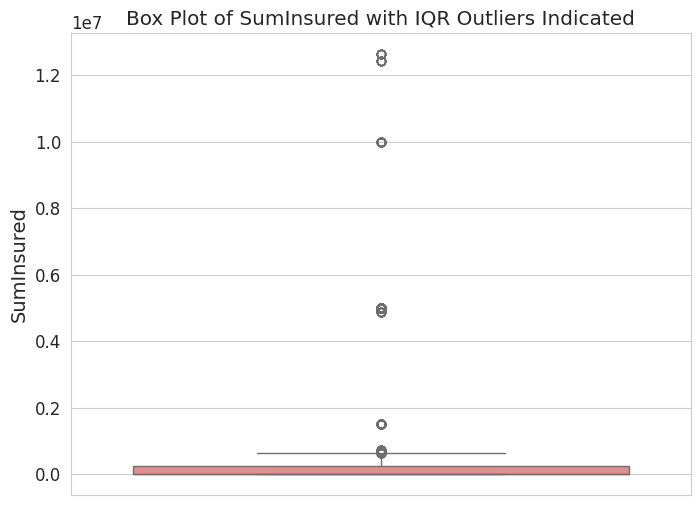

In [60]:
print("\n--- Outlier Detection for Key Numerical Features ---")
outlier_analyzer = OutlierAnalyzer(IQRBasedOutlierAnalysis())

# Define key financial numerical features to check for outliers
financial_cols_for_outliers = ['TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'CalculatedPremiumPerTerm', 'SumInsured']
# Filter for columns that exist in the DataFrame and are numerical
financial_cols_present = [col for col in financial_cols_for_outliers if col in df.columns and pd.api.types.is_numeric_dtype(df[col])]

if financial_cols_present:
    # Analyze outliers in 'TotalClaims', focusing on claims > 0
    if 'TotalClaims' in df.columns:
        claims_only_df = df[df['TotalClaims'] > 0].copy() # Filter for actual claims
        if not claims_only_df.empty:
            print("\n**Analyzing Outliers in TotalClaims (claims > 0):**")
            outlier_analyzer.execute_analysis(claims_only_df, 'TotalClaims')
        else:
            print("No policies with claims > 0 found for detailed outlier analysis on TotalClaims.")
    else:
        print("TotalClaims column not found for outlier analysis.")

    # Analyze outliers in other financial columns
    other_financial_cols = [col for col in financial_cols_present if col != 'TotalClaims']
    for col in other_financial_cols:
        print(f"\n**Analyzing Outliers in {col}:**")
        outlier_analyzer.execute_analysis(df, col)
else:
    print("No specified financial numerical columns found for outlier detection.")


**Interpretation of Outlier Detection:**

- **Presence and Magnitude:** Box plots visually highlight outliers as individual points beyond the "whiskers." The `IQRBasedOutlierAnalysis` quantifies them, showing lower/upper bounds and the count of data points falling outside these bounds.
- **Impact on Analysis:** Outliers can disproportionately influence mean values, inflate standard deviations, and significantly affect models that assume normally distributed errors (e.g., linear regression). For example, a few very large `TotalClaims` outliers can drastically increase the average claim cost.
- **Handling Strategies:**
    - **Investigation:** The first step is always to investigate if outliers are genuine extreme values or data entry errors.
    - **Capping/Winsorization:** For genuine but extreme values, capping (setting values above/below a certain percentile to that percentile's value) can reduce their impact without removing them entirely.
    - **Transformation:** Applying mathematical transformations (e.g., log, square root) can reduce skewness and pull in outliers.
    - **Robust Models:** Tree-based models (like Random Forests or XGBoost) are generally less sensitive to outliers than traditional regression models.
    - **Separate Modeling:** In very specific cases, if outliers represent a distinct phenomenon, they might be modeled separately.

## **7. Key Insights & Creative Visualizations**

Based on the extensive EDA performed, this section presents three compelling and creative visualizations that capture the most significant business insights. Each plot tells a "story" about the data, aiding ACIS in strategic decision-making.

### Creative Plot 1: Loss Ratio by Province with Total Premium Volume


--- Key Insights & Creative Visualizations ---


/tmp/ipykernel_7438/1238394249.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  province_summary_plot = df.groupby('Province').agg(
/tmp/ipykernel_7438/1238394249.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  province_summary_plot['LossRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_7438/1238394249.py:14:

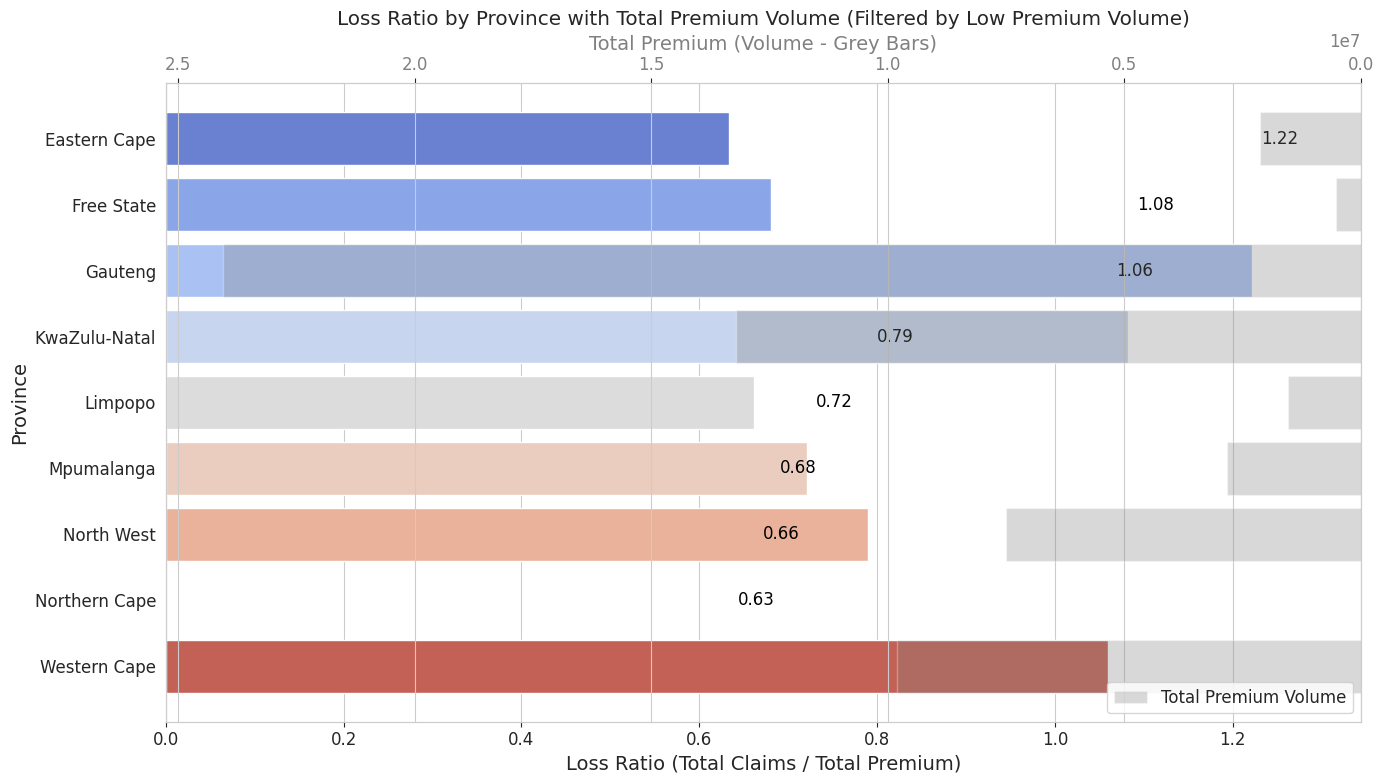

In [61]:
print("\n--- Key Insights & Creative Visualizations ---")

# --- Creative Plot 1: Loss Ratio by Province with Total Premium Volume ---
# This plot visually combines profitability (Loss Ratio) with business volume (Total Premium)
# for each province, providing a holistic view of geographical performance.
if all(col in df.columns for col in ['Province', 'TotalPremium', 'TotalClaims', 'PolicyID']):
    province_summary_plot = df.groupby('Province').agg(
        TotalPremium=('TotalPremium', 'sum'),
        TotalClaims=('TotalClaims', 'sum'),
        PolicyCount=('PolicyID', 'nunique')
    )
    province_summary_plot['LossRatio'] = province_summary_plot['TotalClaims'] / (province_summary_plot['TotalPremium'] + np.finfo(float).eps)
    province_summary_plot['LossRatio'].replace([np.inf, -np.inf], np.nan, inplace=True)
    province_summary_plot['LossRatio'].fillna(0, inplace=True)

    province_summary_plot = province_summary_plot.sort_values('LossRatio', ascending=False).reset_index()

    # Filter out provinces with very low total premium, as their Loss Ratio can be unstable/misleading
    min_premium_volume_threshold = province_summary_plot['TotalPremium'].quantile(0.05) # e.g., consider only top 95% of premium volume provinces
    filtered_province_summary_plot = province_summary_plot[province_summary_plot['TotalPremium'] >= min_premium_volume_threshold].copy()

    if not filtered_province_summary_plot.empty:
        plt.figure(figsize=(14, 8))
        # Primary plot: Bar plot for Loss Ratio, sorted for easy comparison
        bar_plot_lr = sns.barplot(x='LossRatio', y='Province', data=filtered_province_summary_plot, palette='coolwarm')
        plt.xlabel('Loss Ratio (Total Claims / Total Premium)')
        plt.ylabel('Province')
        plt.title('Loss Ratio by Province with Total Premium Volume (Filtered by Low Premium Volume)')
        plt.xlim(0, max(filtered_province_summary_plot['LossRatio']) * 1.1) # Add padding to x-axis

        # Add text labels for Loss Ratio values on the bars
        for index, row in filtered_province_summary_plot.iterrows():
            bar_plot_lr.text(row.LossRatio + 0.01, index, f'{row.LossRatio:.2f}', color='black', ha="left", va="center")

        # Secondary Y-axis (twiny): Plot Total Premium as grey bars to show volume context
        ax2 = plt.gca().twiny()
        ax2_bars = ax2.barh(filtered_province_summary_plot['Province'], filtered_province_summary_plot['TotalPremium'], color='grey', alpha=0.3, label='Total Premium Volume')
        ax2.set_xlabel('Total Premium (Volume - Grey Bars)', color='grey')
        ax2.tick_params(axis='x', labelcolor='grey')
        ax2.invert_xaxis() # Invert secondary x-axis to align its 0 with primary x-axis
        ax2.legend(loc='lower right')

        plt.tight_layout()
        plt.show()
    else:
        print("No sufficient province data after filtering for Plot 1.")
else:
    print("Skipping Plot 1: Required columns ('Province', 'TotalPremium', 'TotalClaims', 'PolicyID') not found.")


**Interpretation (for each plot):**

- **Plot 1 (Loss Ratio by Province with Total Premium Volume):**
    - **Insights:** This visualization effectively segments the portfolio by geography, highlighting both **profitability (Loss Ratio)** and **business volume (Total Premium)**. Provinces with high loss ratios (e.g., above 1.0) signal areas where ACIS is paying out more in claims than it collects in premiums, indicating unprofitability. The grey bars provide critical context: a high loss ratio in a province with significant premium volume is a major concern, while a high ratio in a low-volume province might be an anomaly due to small sample size.
    - **Actionable Advice for ACIS:** Prioritize review of pricing, underwriting, or claims management strategies in high-volume, high-loss ratio provinces. Conversely, low-loss ratio provinces (especially those with substantial premium volume) represent healthy segments where marketing efforts could be intensified to attract more profitable customers.

### Creative Plot 2: Distribution of Claims for Top 5 Vehicle Types, with Average Premium Indication

In [62]:
# --- Creative Plot 2: Distribution of Claims for Top 5 Vehicle Types, with Average Premium Indication ---
# This plot combines a violin plot (showing claim distribution density) with overlaid average premium,
# illustrating risk and value for key vehicle segments.
if all(col in df.columns for col in ['TotalClaims', 'VehicleType', 'PolicyID', 'TotalPremium']):
    claims_present_df_plot = df[df['TotalClaims'] > 0].copy()

    if not claims_present_df_plot.empty:
        # Get top 5 vehicle types by total claims volume (as these are likely the most impactful)
        top_5_vehicle_types = claims_present_df_plot.groupby('VehicleType')['TotalClaims'].sum().nlargest(5).index

        # Filter data for these top types
        df_top_vehicletypes_claims_plot = claims_present_df_plot[claims_present_df_plot['VehicleType'].isin(top_5_vehicle_types)].copy()

        if not df_top_vehicletypes_claims_plot.empty:
            # Calculate average premium for these top vehicle types to overlay
            avg_premium_by_vehicletype = df_top_vehicletypes_claims_plot.groupby('VehicleType')['TotalPremium'].mean().reset_index()
            avg_premium_by_vehicletype = avg_premium_by_vehicletype.set_index('VehicleType')

            plt.figure(figsize=(15, 8))
            # Violin plot shows the full distribution shape (density) of claims for each vehicle type
            violin_plot = sns.violinplot(x='VehicleType', y='TotalClaims', data=df_top_vehicletypes_claims_plot, palette='viridis', inner='quartile')
            plt.yscale('log') # Log scale is essential for heavily skewed financial data like claims
            plt.xlabel('Vehicle Type')
            plt.ylabel('Total Claims (Log Scale)')
            plt.title('Distribution of Total Claims by Top 5 Vehicle Types & Avg. Premium')
            plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability

            # Overlay average premium as text at the bottom of each violin plot
            y_text_pos_multiplier = 0.9 # Adjust this to position text
            for i, vehicle_type_label in enumerate(violin_plot.get_xticklabels()):
                vt_name = vehicle_type_label.get_text()
                if vt_name in avg_premium_by_vehicletype.index:
                    avg_prem_val = avg_premium_by_vehicletype.loc[vt_name, 'TotalPremium']
                    # Position text dynamically near the x-axis, adjusting for log scale
                    plt.text(i, plt.ylim()[0] * (1/plt.ylim()[0]) * avg_prem_val, f'Avg Prem: {avg_prem_val:,.0f}',
                             color='darkred', ha='center', va='bottom', fontsize=10,
                             bbox=dict(boxstyle="round,pad=0.2", fc="yellow", ec="darkred", lw=0.5, alpha=0.7))

            plt.tight_layout()
            plt.show()
        else:
            print("No claims data for top vehicle types found for Plot 2 after filtering.")
    else:
        print("No policies with claims > 0 found for Plot 2.")
else:
    print("Skipping Plot 2: Required columns ('TotalClaims', 'VehicleType', 'PolicyID', 'TotalPremium') not found.")


/tmp/ipykernel_7438/121634693.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_5_vehicle_types = claims_present_df_plot.groupby('VehicleType')['TotalClaims'].sum().nlargest(5).index
/tmp/ipykernel_7438/121634693.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_premium_by_vehicletype = df_top_vehicletypes_claims_plot.groupby('VehicleType')['TotalPremium'].mean().reset_index()
/tmp/ipykernel_7438/121634693.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  v

- **Plot 2 (Distribution of Claims for Top 5 Vehicle Types, with Average Premium Indication):**
    - **Insights:** The violin plots illustrate the full *distribution* of claim amounts for the vehicle types contributing most to claims. This goes beyond simple averages, showing the spread and density of claims (e.g., if claims are clustered at lower values or if there's a long tail of very high claims). The overlaid `Avg Prem` provides a direct comparison: are higher-risk (higher claim) vehicle types adequately priced? Discrepancies (high claims, low premium) pinpoint potential underpricing.
    - **Actionable Advice for ACIS:** Identify vehicle types that consistently lead to higher claim payouts relative to their average premium. This can inform precise premium adjustments (e.g., higher premiums for certain high-risk models), specialized underwriting rules, or even product development tailored to the risk profiles of these vehicle types.

### Creative Plot 3: Temporal Trends of Claim Frequency vs. Average Premium per Policy

/tmp/ipykernel_7438/2213654062.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_metrics_plot = df_temp_plot.resample('M').agg(
/tmp/ipykernel_7438/2213654062.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  monthly_metrics_plot['ClaimFrequency'].fillna(0, inplace=True) # Set freq to 0 if no policies/claims
/tmp/ipykernel_7438/2213654062.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an in

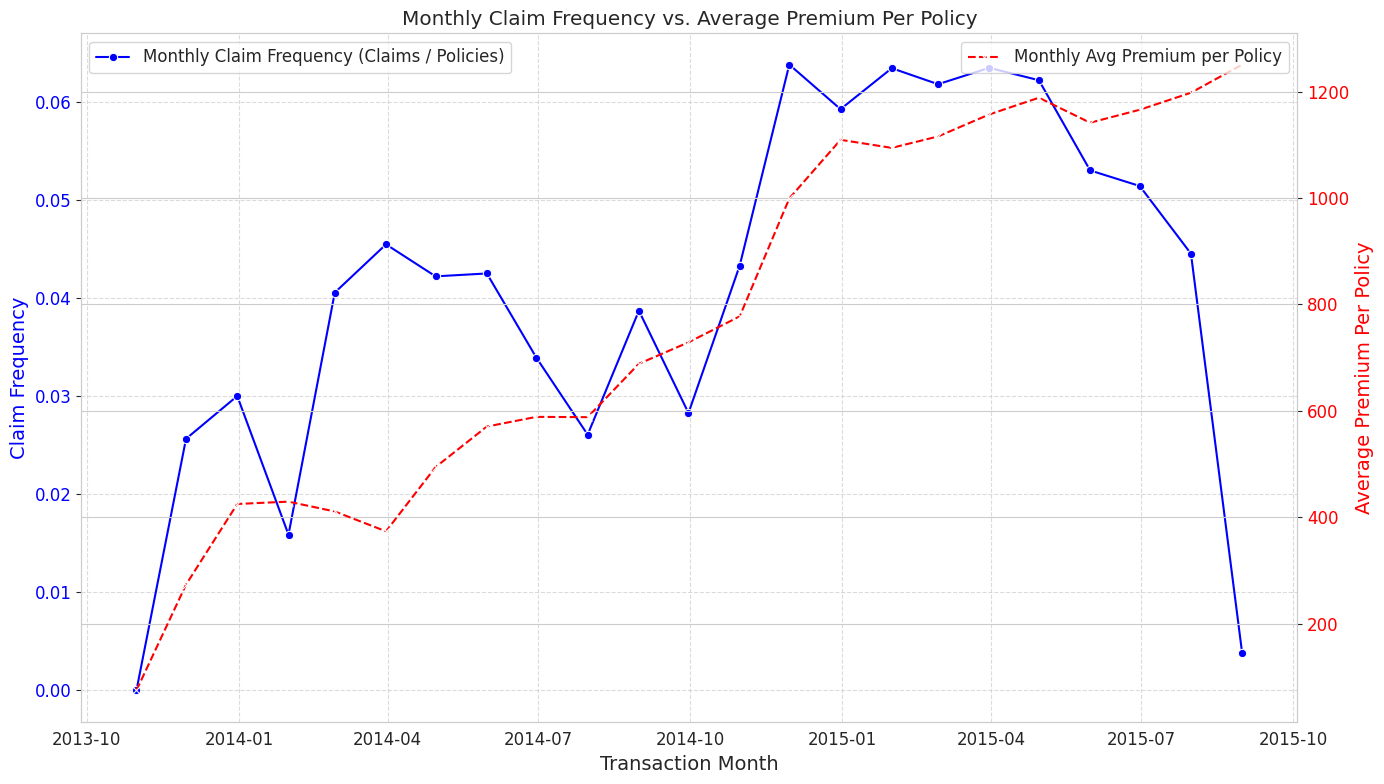

In [63]:

# --- Creative Plot 3: Temporal Trends of Claim Frequency vs. Average Premium per Policy ---
# This plot visualizes the dynamic relationship between how often claims occur (frequency)
# and the average premium charged per policy over time. This helps identify if premium adjustments
# are keeping pace with changes in claims risk.
if all(col in df.columns for col in ['TransactionMonth', 'TotalPremium', 'TotalClaims', 'PolicyID']) and pd.api.types.is_datetime64_any_dtype(df['TransactionMonth']):
    df_temp_plot = df.set_index('TransactionMonth').sort_index().copy()

    # Aggregate key metrics monthly
    monthly_metrics_plot = df_temp_plot.resample('M').agg(
        TotalPremium=('TotalPremium', 'sum'),
        TotalClaims=('TotalClaims', 'sum'),
        PolicyCount=('PolicyID', 'nunique'),
        ClaimsOccurred=('TotalClaims', lambda x: (x > 0).sum()) # Count policies with actual claims (non-zero)
    ).fillna(0) # Fill months with no data with 0

    # Calculate Claim Frequency and Average Premium Per Policy
    # Add small epsilon to denominator to prevent division by zero, then handle inf/nan
    monthly_metrics_plot['ClaimFrequency'] = monthly_metrics_plot['ClaimsOccurred'] / (monthly_metrics_plot['PolicyCount'] + np.finfo(float).eps)
    monthly_metrics_plot['AvgPremiumPerPolicy'] = monthly_metrics_plot['TotalPremium'] / (monthly_metrics_plot['PolicyCount'] + np.finfo(float).eps)

    monthly_metrics_plot.replace([np.inf, -np.inf], np.nan, inplace=True)
    monthly_metrics_plot['ClaimFrequency'].fillna(0, inplace=True) # Set freq to 0 if no policies/claims
    monthly_metrics_plot['AvgPremiumPerPolicy'].fillna(0, inplace=True) # Set avg premium to 0 if no policies

    if not monthly_metrics_plot.empty:
        fig, ax1 = plt.subplots(figsize=(14, 8))

        # Plot Claim Frequency on the primary y-axis (left)
        sns.lineplot(ax=ax1, data=monthly_metrics_plot, x=monthly_metrics_plot.index, y='ClaimFrequency',
                     marker='o', color='blue', label='Monthly Claim Frequency (Claims / Policies)')
        ax1.set_xlabel('Transaction Month')
        ax1.set_ylabel('Claim Frequency', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_title('Monthly Claim Frequency vs. Average Premium Per Policy')
        ax1.legend(loc='upper left')
        ax1.grid(True, linestyle='--', alpha=0.7)

        # Create a second y-axis (twinx) for Average Premium Per Policy (right)
        ax2 = ax1.twinx()
        sns.lineplot(ax=ax2, data=monthly_metrics_plot, x=monthly_metrics_plot.index, y='AvgPremiumPerPolicy',
                     marker='x', color='red', linestyle='--', label='Monthly Avg Premium per Policy')
        ax2.set_ylabel('Average Premium Per Policy', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.legend(loc='upper right')

        fig.tight_layout() # Adjust layout to prevent elements from overlapping
        plt.show()
    else:
        print("Monthly metrics data is empty for Plot 3.")
else:
    print("Skipping detailed temporal plot: Required columns not found or 'TransactionMonth' not in datetime format after preprocessing.")

- **Plot 3 (Temporal Trends of Claim Frequency vs. Average Premium per Policy):**
    - **Insights:** This dual-axis line plot reveals the dynamic interplay between **how often claims occur (Claim Frequency)** and the **average revenue per policy (Average Premium per Policy)** over time. It can expose crucial trends like seasonality in claims (e.g., spikes during certain months), or whether average premiums are adjusting to keep pace with changing claim frequencies. If claim frequency rises significantly without a corresponding increase in average premium, it indicates deteriorating profitability.
    - **Actionable Advice for ACIS:** Use observed trends for financial forecasting and resource allocation (e.g., anticipating higher claims processing needs during peak frequency months). Identify periods where claim frequency outpaces premium adjustments to recommend proactive pricing reviews. This also helps in evaluating the historical effectiveness of business decisions (e.g., a marketing campaign's impact on policy count vs. claim frequency).

## **8. Statistical Thinking Summary**

Integrating statistical thinking throughout EDA is crucial for transforming raw data observations into actionable business intelligence. Here's a summary of how it's applied in this notebook:

- **Distributions:** Analysis of histograms and bar charts (Section 4) helps us understand the `shape` (e.g., right-skewed for financial data), `modality` (single or multiple peaks), and `spread` of individual variables. For instance, the highly right-skewed `TotalClaims` distribution immediately signals that a few very large claims significantly influence the average, a fundamental characteristic of insurance risk.
- **Variability:** Beyond simple averages, measures like `standard deviation`, `variance`, and especially the `Coefficient of Variation (CV)` (Section 3.2) quantify data dispersion. A high CV for `TotalClaims` (relative to its mean) emphasizes the high inherent uncertainty in predicting individual claim amounts, necessitating robust models that can handle such volatility.
- **Outliers:** Box plots and the IQR method (Section 6) are statistical tools for systematically identifying data points that deviate significantly. Recognizing outliers and understanding their magnitude is vital because they can disproportionately skew descriptive statistics and impact the performance of certain machine learning algorithms. Strategic decisions regarding outlier handling (investigation, capping, transformation) are based on their statistical implications.
- **Associations & Correlations:** Correlation matrices and scatter plots (Section 5.2) statistically quantify and visualize the linear relationships between numerical variables. Observing strong correlations (e.g., between vehicle value and premium) confirms expected relationships, while weak or unexpected correlations can highlight areas where the current understanding of risk factors might be incomplete, guiding further feature engineering.
- **Trends & Aggregations:** Aggregating data over time (Section 5.3) and calculating segment-specific KPIs like Loss Ratio (Section 5.1) are forms of statistical summarization. They reveal macro-level patterns, seasonality, and the profitability performance of different customer or product segments. The interpretation of these trends directly informs strategic business decisions, from pricing adjustments to targeted marketing.

This refined EDA, underpinned by solid statistical methodology and modular Python code, provides ACIS with a comprehensive, data-driven understanding of its car insurance portfolio, enabling informed decisions for optimizing pricing, marketing, and risk management.